# 1. Load and imports

In [1]:
from eda import *
from pre_process import *
from topic_modeling import *
from percent import *
from itertools import chain
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from sentence_transformers import SentenceTransformer
from transformers import FlaubertModel
from transformers import CamembertModel
from bertopic import BERTopic




import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pickle
import plotly.express as px


/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/treetaggerwrapper.py:739: FutureWarning: Possible nested set at position 8
  punct2find_re = re.compile("([^ ])([[" + ALONEMARKS + "])",
/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/treetaggerwrapper.py:2043: FutureWarning: Possible nested set at position 152
  DnsHostMatch_re = re.compile("(" + DnsHost_expression + ")",
/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/treetaggerwrapper.py:2067: FutureWarning: Possible nested set at position 409
  UrlMatch_re = re.compile(UrlMatch_expression, re.VERBOSE | re.IGNORECASE)
/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/treetaggerwrapper.py:2079: FutureWarning: Possible nested set at position 192
  EmailMatch_re = re.compile(EmailMatch_expression, re.VERBOSE | re.IGNORECASE)


In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
df = pd.read_csv('./../../Data/Dataframes/eulogies.csv')

In [4]:
df = df[((df['Annee']>1793) & (df['Annee']<1832))|(df['Auteur'] =='Condorcet')]

# 2. First axis : basic statistics

## Removing \n, \t, non-useful spaces

In [5]:
df['Eloge'] = df['Eloge'].apply(lambda x : x.replace("\\n", "").replace("\\t", "").replace("\n", "").replace("\t", "")
                               .strip())

In [6]:
df.head()

,Savant,Auteur,Annee,Eloge
0,Fontaine,Condorcet,1771,Alexis Fontaine naquit à Claveison en Dauphiné...
1,Perrault,Condorcet,1773,"Claude Perrault naquit à Paris, vers l’an 1613..."
2,de la Chambre,Condorcet,1773,"[Condorcet avait mis, en marge de cette premiè..."
3,Frenicle,Condorcet,1773,"Nicolas Frenicle de Bessy, conseiller à la cou..."
4,Boyle,Condorcet,1773,On ignorait encore en Angleterre en 1666 les e...


## a. Number of eulogies

In [7]:
print('There are ' + str(df.shape[0]) + ' eulogies') 
print('There are ' + str(df[df['Annee']<1793].shape[0]) + ' eulogies before the French Revolution')
print('There are ' + str(df[df['Annee']>=1793].shape[0]) + ' eulogies after the French Revolution')

There are 144 eulogies
There are 78 eulogies before the French Revolution
There are 66 eulogies after the French Revolution


In [8]:
df['Auteur'].nunique()

12

## b. Number of eulogies per year

array([[<AxesSubplot:title={'center':'Annee'}>]], dtype=object)

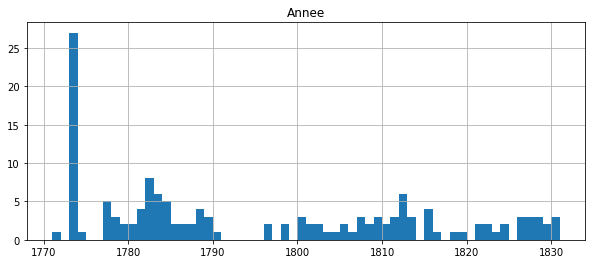

In [9]:
nbins = int(df['Annee'].max() - df['Annee'].min())
#nbins
df.hist('Annee', bins = nbins, figsize = (10,4))

In [10]:
df_help = df.groupby(['Annee'])['Savant'].count().reset_index().rename(columns = {'Savant' : 'count'})

df_pre = df_help[df_help['Annee']<=1793]
df_post = df_help[df_help['Annee']>1793]

In [11]:
from scipy.stats import ttest_ind

ttest_ind(df_pre['count'].array, df_post['count'].array)

Ttest_indResult(statistic=2.1043725964483397, pvalue=0.04096396730552059)

## b. Length of the eulogies

In [12]:
side_info(df)

df['Eloge'] = df['Eloge'].apply(lambda x : x.replace('enfans', 'enfants').replace('instrumens', 'instruments')
                               .replace('talens', 'talents').replace('différens', 'différents').replace(
                               'monumens', 'monuments').replace('évènemens', 'évènements').replace('savans',
                                                                                                  'savants').
                               replace('documens', 'documents').replace('long-temps', 'longtemps'))

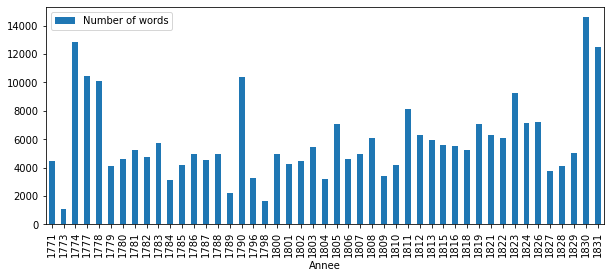

In [13]:
nbr_words_df = nbr_words(df, evol = True)

In [14]:
nbr_words_pre = nbr_words_df[nbr_words_df['Annee']<1793]
nbr_words_post = nbr_words_df[nbr_words_df['Annee']>=1793]

ttest_ind(nbr_words_pre['Number of words'].array, nbr_words_post['Number of words'].array)

Ttest_indResult(statistic=-0.20132239463632692, pvalue=0.8413537641053238)

## c. Average word length

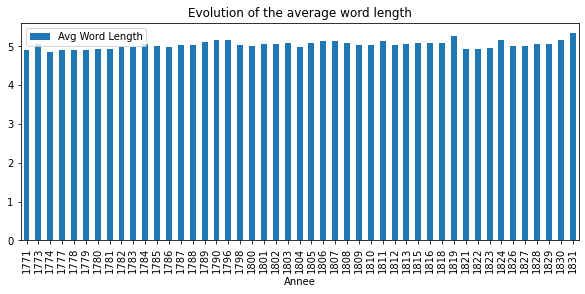

In [15]:
avg_words = avg_word_length(df, evol = True)

In [16]:
avg_words_pre = avg_words[avg_words['Annee']<=1793]
avg_words_post = avg_words[avg_words['Annee']>1793]

ttest_ind(avg_words_pre['Avg Word Length'].array, avg_words_post['Avg Word Length'].array)

Ttest_indResult(statistic=-3.564138780912023, pvalue=0.0008782494879042457)

## d. Average sentence length

100%|███████████████████████████████████████| 144/144 [00:00<00:00, 1237.81it/s]


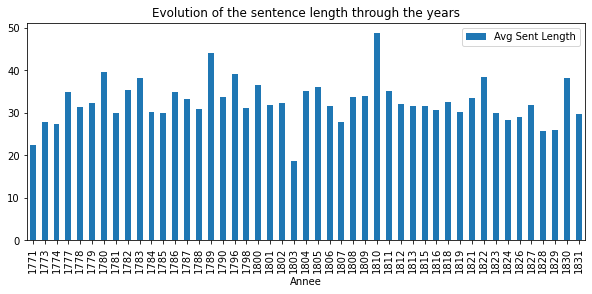

In [17]:
avg_sentence_df = avg_sentence(df, evol = True)

In [18]:
avg_sentence_pre = avg_sentence_df[avg_sentence_df['Annee']<1793]
avg_sentence_post = avg_sentence_df[avg_sentence_df['Annee']>=1793]

ttest_ind(avg_sentence_pre['Avg Sent Length'].array, avg_sentence_post['Avg Sent Length'].array)

Ttest_indResult(statistic=0.23408579598751392, pvalue=0.8159801235220794)

## e. Use of first person

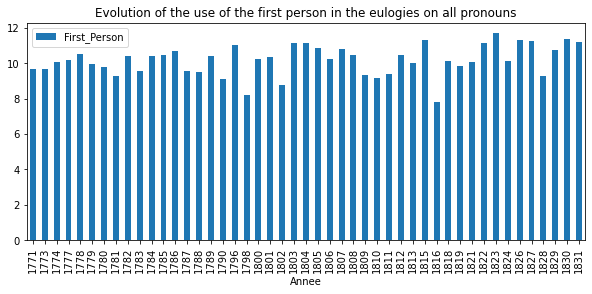

In [19]:
fst_person = first_person(df)

In [20]:
fst_person_pre = fst_person[fst_person['Annee']<1793]
fst_person_post = fst_person[fst_person['Annee']>=1793]

ttest_ind(fst_person_pre['First_Person'].array, fst_person_post['First_Person'].array)

Ttest_indResult(statistic=-1.3659039643825415, pvalue=0.17875724280276334)

## f. Use of modals

100%|████████████████████████████████████████| 144/144 [00:00<00:00, 895.43it/s]


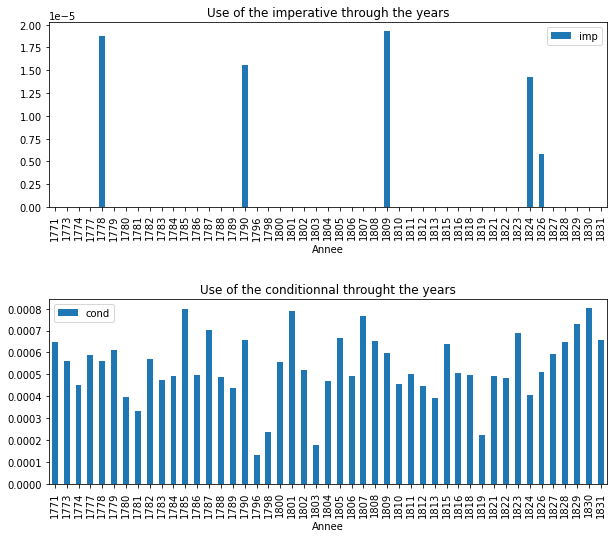

In [21]:
pci = cond_imperative(df)

In [136]:
c_adv = count_adverbs(df)

100%|█████████████████████████████████████████| 144/144 [00:37<00:00,  3.80it/s]


In [137]:
c_adv.sort_values(by = 'Number', ascending = False, inplace = True)
c_adv.reset_index(inplace = True)
c_adv.pop('index')
c_adv

,Adverb,Number
0,plus,5933
1,ne,5339
2,pas,3139
3,n,2310
4,encore,1404
...,...,...
477,manifestement,1
478,mathmatiquement,1
479,mauvais,1
480,mcaniquement,1


In [138]:
c_adv_pc = c_adv[c_adv['Number']>=5]
c_adv_pc['Categorie'] = 'default value'

- si loc 5
- que loc 52
- qu loc 83
- rien
- voilà 95
- voici 150
- minnement 183
- avec 196
- vice 220


In [139]:
c_adv_pc_old = pd.read_csv('./../../Data/Results/Adverbs.csv')

In [140]:
c_adv_pc['Assertivité'] = 'default value'

In [141]:
c_adv_tot = pd.merge(c_adv_pc, c_adv_pc_old, on = 'Adverb', how = 'left')

In [149]:
c_adv_tot.head()

,Adverb,Number,Categorie,Assertivité,Temporalité
0,plus,5933,quantité,default value,default value
1,ne,5339,négation,default value,default value
2,pas,3139,négation,default value,default value
3,n,2310,négation,default value,default value
4,encore,1404,temps_quantité_logique,default value,default value


In [146]:
c_adv_tot.pop('Number_y')

0      5933
1      5339
2      3139
3      2310
4      1404
       ... 
252       5
253       5
254       5
255       5
256       5
Name: Number_y, Length: 257, dtype: int64

In [148]:
c_adv_tot.rename(columns = {'Number_x' : 'Number', 'Assertivité_y' : 'Assertivité', 'Categorie_y' : 'Categorie'},
                inplace = True)

In [175]:
c_adv_tot['Temporalité'] = 'default value'
c_adv_tot['Experience'] = 'default value'

In [150]:
c_adv_tot.to_csv('./../../Data/Results/Adverbs.csv', index=False)

In [188]:
modals = [x for x, y in zip(c_adv_pc['Adverb'], c_adv_pc['Categorie']) if 'modal' in y]
modals

['naturellement',
 'aisment',
 'malheureusement',
 'certainement',
 'apparemment',
 'clairement',
 'communment',
 'spcialement',
 'minemment',
 'vraisemblablement',
 'personnellement',
 'incomparablement']

In [186]:
df['Modals_adv'] =df['Eloge'].apply(lambda x : [word for word in x.split() if word in modals])

In [190]:
modals = df.groupby(['Annee'])['Modals_adv'].apply(list).reset_index()
modals.head()

,Annee,Modals_adv
0,1741,[[naturellement]]
1,1742,"[[], [], [naturellement]]"
2,1743,"[[vraisemblablement], [vraisemblablement], [na..."
3,1744,[[]]
4,1746,[[]]


In [192]:
modals['Modals_adv'] = modals['Modals_adv'].apply(lambda x : sum([len(ls) for ls in x]))


<AxesSubplot:xlabel='Annee'>

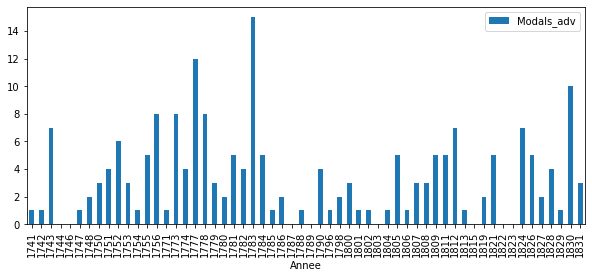

In [197]:
modals.plot('Annee', 'Modals_adv', kind = 'bar', figsize = (10,4))

## g. Use of past tenses

100%|███████████████████████████████████████| 144/144 [00:00<00:00, 3082.44it/s]


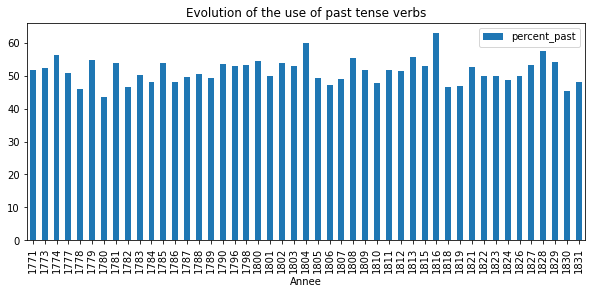

In [22]:
past_tense = past_tense(df)

In [23]:
past_tense_pre = past_tense[past_tense['Annee']<1793]
past_tense_post = past_tense[past_tense['Annee']>=1793]

ttest_ind(past_tense_pre['percent_past'].array, past_tense_post['percent_past'].array)

Ttest_indResult(statistic=-1.1382716668903345, pvalue=0.2610310346186218)

Reject Null Hypothesis the means are statistically different

## h. Starts with a statement on the birth

In [24]:
naissance(df)

In [25]:
df[df['naissance'] == False].shape[0]

51

In [26]:
df[(df['naissance'] == False)&(df['Annee']<1793)].shape[0]

16

In [27]:
df[(df['naissance'] == False)&(df['Annee']>=1793)].shape[0]

35

## i. Use of Proper Names


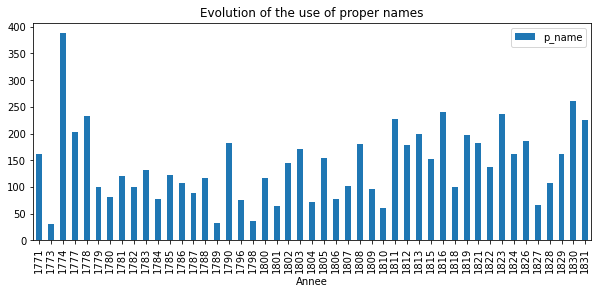

In [28]:
p_n = proper_name(df)

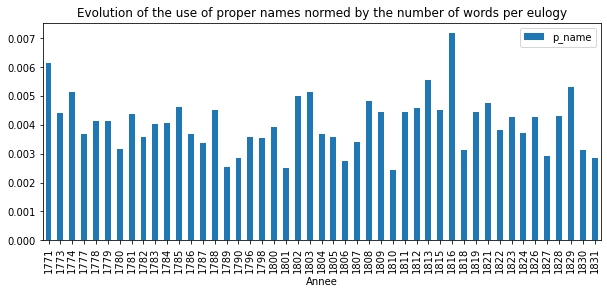

In [29]:
p_norm = proper_name(df, norm = True)

# 3. Second axis : Topic modeling

## Divide the dataframe into sentences

In [21]:
#https://stackoverflow.com/questions/50731229/split-cell-into-multiple-rows-in-pandas-dataframe
def chainer(s):
    return list(chain.from_iterable(s.str.split('.')))

#Replace M. for Monsieur with M for the splitting
df['Eloge'] = df['Eloge'].apply(lambda x : x.replace('M.', 'M'))
lens = df['Eloge'].str.split('.').map(len)

# create new dataframe, repeating or chaining as appropriate
sent = pd.DataFrame({'Savant': np.repeat(df['Savant'], lens),
                    'Auteur': np.repeat(df['Auteur'], lens),
                     'Annee' : np.repeat(df['Annee'], lens),
                    'Eloge': chainer(df['Eloge'])})

sent = sent[(sent['Eloge'] != ' ') &  (sent['Eloge'] != '') & (sent['Eloge'].str.len()>10)]

In [22]:
sent.head()

,Savant,Auteur,Annee,Eloge
0,Fontaine,Condorcet,1771,Alexis Fontaine naquit à Claveison en Dauphiné...
0,Fontaine,Condorcet,1771,Il avait environ vingt ans lorsque son père m...
0,Fontaine,Condorcet,1771,Ses parents auraient voulu qu’il suivit les é...
0,Fontaine,Condorcet,1771,Né avec cette rigueur d’esprit que les démons...
0,Fontaine,Condorcet,1771,Tourmenté par les sollicitations de ses paren...


In [23]:
#Preprocessing the sentences
rmv_sw(sent, name_col = 'Eloge')
rmv_punkt(sent)
lemmatize(sent, 'no_sw_no_punkt', 'tags')
rmv_digit(sent)

In [24]:
#Only keeping nouns and verbs to avoid noise
nouns_verbs(sent, 'Eloge_lem')

100%|█████████████████████████████████| 17177/17177 [00:00<00:00, 114583.56it/s]


In [25]:
sent.reset_index(inplace = True)
sent.drop('index', axis = 1, inplace = True)
sent.head()

,Savant,Auteur,Annee,Eloge,no_sw,no_sw_no_punkt,tags,Eloge_lem,n_v
0,Fontaine,Condorcet,1771,Alexis Fontaine naquit à Claveison en Dauphiné...,"Alexis Fontaine naquit Claveison Dauphiné, l’a...",Alexis Fontaine naquit Claveison Dauphiné l a...,"[(Alexis, NAM, Alexis), (Fontaine, NAM, Fontai...",Alexis Fontaine naître Claveison Dauphiné l an...,naître l année card
1,Fontaine,Condorcet,1771,Il avait environ vingt ans lorsque son père m...,ans père mourut,ans père mourut,"[(ans, NOM, an), (père, NOM, père), (mourut, V...",an père mourir,an père mourir
2,Fontaine,Condorcet,1771,Ses parents auraient voulu qu’il suivit les é...,"Ses parents voulu qu’il suivit études droit, n...",Ses parents voulu qu il suivit études droit n...,"[(Ses, DET:POS, son), (parents, NOM, parents),...",son parents vouloir qu il suivre étude droit n...,vouloir suivre étude exercer charge styler com...
3,Fontaine,Condorcet,1771,Né avec cette rigueur d’esprit que les démons...,"rigueur d’esprit démonstrations satisfaire, do...",rigueur d esprit démonstrations satisfaire do...,"[(rigueur, NOM, rigueur), (d, VER:futu, d), (e...",rigueur d esprit démonstration satisfaire donn...,rigueur d esprit démonstration satisfaire donn...
4,Fontaine,Condorcet,1771,Tourmenté par les sollicitations de ses paren...,"Tourmenté sollicitations parents, l’activité g...",Tourmenté sollicitations parents l activité g...,"[(Tourmenté, VER:pper, tourmenter), (sollicita...",tourmenter sollicitation parent l activité gén...,tourmenter sollicitation l activité génie prov...


In [26]:
#Removing stop words and really short words that might still be here
sent['n_v'] = sent['n_v'].apply(lambda x : ' '.join([elem for elem in x.split() if (elem not in fr_stop and 
                                                                                    len(elem)>2)]))

## Embedding models

I tested different embedding models and chose to stay with the sentence transformer as it was the one working  the best

In [84]:
np.random.seed(123)

model_sent = SentenceTransformer('distiluse-base-multilingual-cased-v1')

#modelname = 'flaubert/flaubert_base_cased' 
#flaubert, log = FlaubertModel.from_pretrained(modelname, output_loading_info=True)

#camembert = CamembertModel.from_pretrained('camembert/camembert-base-wikipedia-4gb')

## Bertopic

In [85]:
#Loading Bertopic with embedding model chosen and nr_topics to auto so that topic with more than 0.9 similarity are
#merged
model = BERTopic(embedding_model = model_sent, min_topic_size = 30,
                 nr_topics='auto',calculate_probabilities = True)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [86]:
topics, probabilities = model.fit_transform(sent.n_v)

In [27]:
#with open("./../../Data/Results/topics", "wb") as fp:   #Pickling
 #   pickle.dump(topics, fp)
 
with open("./../../Data/Results/topics", "rb") as fp:   # Unpickling
    topics = pickle.load(fp)


In [28]:
#with open("./../../Data/Results/probabilities", "wb") as fp:   #Pickling
 #   pickle.dump(probabilities, fp)
    
    
with open("./../../Data/Results/probabilities", "rb") as fp:   # Unpickling
    probabilities = pickle.load(fp)

In [29]:
df_rep = pd.DataFrame({'Topic': topics, 'Document': sent.n_v, 'Eloge' : sent.Eloge, 'Annee' : sent.Annee,
                      'Savant' : sent.Savant, 'Auteur' : sent.Auteur})

df_rep['Prob'] = df_rep.apply(lambda row : probabilities[row.name][row['Topic']], axis = 1)

In [90]:
pd.set_option('display.max_rows', 200)

In [91]:
#df_info.to_csv('./../../Data/Results/topic_modeling_sentence.csv')
#df_info = pd.read_csv('./../../Data/Results/topic_modeling_sentence.csv', index_col = 0)
#df_info.head(1)

In [30]:
#model.save('./../../Data/Results/bert_model')
model = BERTopic.load('./../../Data/Results/bert_model')

In [151]:
_ = sent_rep(23, df_rep)

 Combien il a été trompé dans son attente ! Malgré les précautions prises d'avance, rien ne se trouva prêt à son arrivée en Espagne ; les ordres de la cour n'avoient pas été expédiés dans la forme convenable ; le commandant du brigantin qui était mis à sa disposition pour le conduire du continent aux îles et des îles au continent, toutes les fois que les opérations l'exigeraient, ne se crut pas suffisamment autorisé ; il fallut solliciter de nouveau


 Dolomieu, qui avait ignoré que l'expédition commencerait par la prise de cette île, se renferme, profondément affligé, dans le bâtiment qui l'avait amené


 Si l'on songe que le capitaine Cook se brouilla avec les deux Forster, qui remplacèrent dans ce second voyage MM Banks et Solander ; que dans le troisième il refusa d'emmener aucun naturaliste, qu'il n'y en a pas eu depuis sur les expéditions nautiques des Anglais, et que ceux qui se sont embarqués sur les nôtres, ont cru bien rarement avoir à se louer de leurs conducteurs, on trouve

In [31]:
df_info = model.get_topic_info()
df_info

,Topic,Count,Name
0,-1,9017,-1_faire_homme_pouvoir_donner
1,0,678,0_card_année_publier_mémoire
2,1,671,1_planter_plante_espèce_jardin
3,2,591,2_science_progrès_homme_vérité
4,3,502,3_fil_père_fils_famille
5,4,365,4_médecin_médeciner_maladie_remède
6,5,357,5_astronome_astronomie_soleil_observation
7,6,320,6_pierre_montagne_rocher_volcan
8,7,303,7_air_sel_gaz_alcali
9,8,292,8_euler_équation_calcul_méthode


## Hierarchical clustering

In [86]:
#13, 
#Manually creating topics
topic_discipline = [4, 5, 6, 11, 14, 15, 25, 33,  42, 43]
topic_element = [1, 2, 7, 8, 18, 22, 26, 28, 35, 36, 44, 47]
topic_vie = [0, 3, 20, 24, 30, 31, 32, 41,17, 29]
topic_politique = [9, 10, 12, 19, 38, 39, 48]
#topic_ouvrage = []
topic_voyage = [23, 37]
topic_religion = [21]
topic_qualite = [46, 45, 13, 40]
topic_memoire = [27, 34, 16]

In [87]:
topic_dict = {'discipline' : topic_discipline, 'element' : topic_element, 'vie' : topic_vie, 
             'politique' : topic_politique,  'religion' : topic_religion, 
              'voyage' : topic_voyage, 'qualite' : topic_qualite, 'memoire' : topic_memoire}
#'ouvrage' : topic_ouvrage,

In [88]:
#higher topics

topic_science = topic_discipline + topic_element
topic_personne = topic_vie + topic_qualite 
topic_posterite = topic_memoire #+ topic_ouvrage
topic_societe = topic_religion + topic_politique

In [89]:
high_dict = {'science' : topic_science, 'personne' : topic_personne, 'posterite' : topic_posterite,
                                                                          'societe' : topic_societe,
            'voyage' : topic_voyage}

In [90]:
model.visualize_hierarchy()

In [91]:
df_plot = df_info.copy()
df_plot['High_High_Topic'] = df_plot['Topic'].apply(lambda x : major_topic(x, high_dict)[1])
df_plot['High_Topic'] = df_plot['Topic'].apply(lambda x : major_topic(x)[1])
df_plot = df_plot[df_plot['High_Topic']!='outlier']

fig = px.icicle(df_plot, path=[px.Constant("all"), 'High_High_Topic', 'High_Topic', 'Name'])
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

## Topics over time

In [155]:
#with open("./../../Data/Results/topics", "rb") as fp:   # Unpickling
#    topics = pickle.load(fp)
    

df_top = pd.DataFrame({'Topic': topics, 'Document': sent.n_v, 'Eloge' : sent.Eloge, 'Annee' : sent.Annee,
                      'Savant' : sent.Savant, 'Auteur' : sent.Auteur})
df_top.head()

,Topic,Document,Eloge,Annee,Savant,Auteur
0,0,naître année card,Alexis Fontaine naquit à Claveison en Dauphiné...,1771,Fontaine,Condorcet
1,-1,père mourir,Il avait environ vingt ans lorsque son père m...,1771,Fontaine,Condorcet
2,-1,vouloir étude exercer charge styler commentate...,Ses parents auraient voulu qu’il suivit les é...,1771,Fontaine,Condorcet
3,-1,rigueur esprit démonstration satisfaire donner...,Né avec cette rigueur d’esprit que les démons...,1771,Fontaine,Condorcet
4,13,tourmenter sollicitation activité génie provin...,Tourmenté par les sollicitations de ses paren...,1771,Fontaine,Condorcet


In [157]:
df_top[df_top['Topic']==12]

,Topic,Document,Eloge,Annee,Savant,Auteur
389,12,roi contenter honneur protéger homme illustrer...,Le roi de Danemark ne se contenta pas de l’ho...,1773,Roëmer,Condorcet
556,12,prince appeler honneur distinguer envoyer yach...,"Ce prince l’avait appelé, et lui avait fait m...",1773,Charas,Condorcet
561,12,Charas craindre rigueur inquisition respecter ...,Charas craignait les rigueurs de l’inquisiti...,1773,Charas,Condorcet
713,12,calomnier successeur ôter ile aller chercher p...,"Tous le calomnièrent auprès de Christien, suc...",1773,Picard,Condorcet
714,12,mourir palais nom Brahé éclat titre histoire e...,"Tycho mourut dans son palais, laissant au nom...",1773,Picard,Condorcet
...,...,...,...,...,...,...
16815,12,dlivier arrivérent roi vouloir dépouiller scha...,"Mais, lorsque MM Bruguières et dlivier y arri...",1816,Olivier,Cuvier
16820,12,roi sagesse vertu schah lsmail voir connaissar...,"Ce roi avait, selon lui, la sagesse et les ve...",1816,Olivier,Cuvier
16821,12,schah talent braivoure nadir schah justé roi f...,"Schah-Abbas, les talents militaires et la bra...",1816,Olivier,Cuvier
16998,12,personnage illustrer royaume assister obsèques,Les personnages les plus illustres du royaume...,1818,Werner,Cuvier


In [93]:
df_top['Words'] = df_top['Topic'].apply(lambda x : df_info[df_info['Topic']==x].reset_index()['Name'][0])
df_top['Words'] = df_top['Words'].apply(lambda x : ', '.join(x.split('_')[1:]))

In [94]:
#Normalize by number of sentences

topics_over_time_norm = df_top.groupby(['Annee', 'Topic', 'Words'])['Eloge'].count().reset_index()
topics_over_time_norm.rename(columns = {'Annee' : 'Timestamp', 'Eloge' : 'Frequency'}, inplace = True)

topics_over_time_norm.head()

,Timestamp,Topic,Words,Frequency
0,1771,-1,"faire, homme, pouvoir, donner",63
1,1771,0,"card, année, publier, mémoire",5
2,1771,1,"planter, plante, espèce, jardin",2
3,1771,2,"science, progrès, homme, vérité",2
4,1771,3,"fil, père, fils, famille",4


In [95]:
df_by_year = df.groupby('Annee')['Eloge'].count().reset_index()
sent_by_year = sent.groupby('Annee')['Eloge'].count().reset_index()

In [96]:
sent_topic_time = topics_over_time_norm.copy()

topics_over_time_norm = pd.merge(topics_over_time_norm, df_by_year, left_on = 'Timestamp', right_on = 'Annee', 
                                how = 'left')
topics_over_time_norm.head()

,Timestamp,Topic,Words,Frequency,Annee,Eloge
0,1771,-1,"faire, homme, pouvoir, donner",63,1771,1
1,1771,0,"card, année, publier, mémoire",5,1771,1
2,1771,1,"planter, plante, espèce, jardin",2,1771,1
3,1771,2,"science, progrès, homme, vérité",2,1771,1
4,1771,3,"fil, père, fils, famille",4,1771,1


In [97]:
sent_topic_time = pd.merge(sent_topic_time, sent_by_year, left_on = 'Timestamp', right_on = 'Annee', 
                                how = 'left')

In [98]:
topics_over_time_norm['Frequency'] = topics_over_time_norm.apply(lambda row : row['Frequency']/row['Eloge'],
                                                                axis = 1)
topics_over_time_norm.pop('Eloge')
topics_over_time_norm.pop('Annee')

sent_topic_time['Frequency'] = sent_topic_time.apply(lambda row : row['Frequency']/row['Eloge'],
                                                                axis = 1)
sent_topic_time.pop('Eloge')
sent_topic_time.pop('Annee')

0       1771
1       1771
2       1771
3       1771
4       1771
        ... 
1504    1831
1505    1831
1506    1831
1507    1831
1508    1831
Name: Annee, Length: 1509, dtype: int64

In [99]:
def major_topic(topic, ls = topic_dict):
    for idx, entri in enumerate(ls.items()) :
        if topic in entri[1] :
            return idx ,entri[0]
    return -1, 'outlier'

In [100]:
bins = sent.Annee.unique().shape[0]
topics_over_time = model.topics_over_time(sent.n_v, topics, sent.Annee, nr_bins=bins)
topics_over_time

,Topic,Words,Frequency,Timestamp
0,-1,"homme, méchanceté, gloire, vanité, mériter",63,1770.940
1,0,"card, cuiseaux, seigneurie, préfacer, comté",5,1770.940
2,1,"légataire, anel, fermier, aversion, obligation",2,1770.940
3,2,"entrée, vendre, dessein, choser, précéder",2,1770.940
4,3,"castel, père, fil, eur, succession",4,1770.940
...,...,...,...,...
1275,41,"problème, été, ami, adresse, pallas",1,1829.723
1276,43,"électricité, tonnerre, analogie, attouchement,...",24,1829.723
1277,45,"grimaldi, esprit, diffraction, condisciple, bo...",5,1829.723
1278,46,"obsèques, pompe, célébrer, volter, regret",1,1829.723


In [101]:
#Normalized by number of sentences

model.visualize_topics_over_time(sent_topic_time)

In [102]:
#Normalized by number of eulogies

model.visualize_topics_over_time(topics_over_time_norm)

- Topic 0, pic en 1830
- Augmentation des plantes après 1800 topic 1
- Moins de parler sur la famille entre 1790 et 1810 topic 3
- Euler plus mentionné avant rev 2 pics en 1773 et 1785 topic 8
- Pic pour géométrie en 1773 topic 14
- Théorie, expérience explication plus évoqué à partir de 1820 topic 28
- Médecine plus évoqué pré revolution pic en 1827-1828 topic 4
- Astronomie plus évoquée post révolution
- Pierre, montagne, rocher trps évoqué de 1818 à 1823 topic 6
- Air, sel, gaz, alcali beaucoup plus évoqué post rev pic en 1830 topic 7
- Chimie légèrement plus évoquée dans les années 20 topic 11
- Prince, roi, condé plus évoquée pre rev avec pic juste après 1815
- Philosophie plus évoquée avant la révolution topic 15
- Rayon, lumière, rayer pic en 1830 topic 18
- Ministère plus évoquée pre-rev pic en 1790 topic 19
- Professeur beaucoup plus évoqué post-rev pic topic 20
- Religion beaucoup plus évoquée pre-rev topic 21
- Expérience, confirmer, Mariotte, faire pic en 1830 topic 22
- Ile, vaisseau, baks, capitaine plus évoqué post rev topic 23
- Pic pour anatomie entre 1800 et 1805 topic 25
- Jeunesse age plus évoqué post rev topic 32
- Pic de langue traduire entre 1785 et 1790 topic 34
- Pic pour voyage entre 1815 et 1820 topic 37
- Horloge plus évoquée après 1808 pic en 1809 et 1827
- Pic pour marquis maréchal en 1787-1788 topic 48
- Pic pour loi, peuple nation en 1779 et 1790 topic 9
- Pic pour électricité tonnerre analogie en 1830 topic 43
- Topic impôt peuple natino disparaît après 1805 pic en 1776 et 1790
- Topic Révolution beaucoup plus évoqué avant 1805 pic en 1790 et 1805

- Pic en 1776 et augmentation de 1787 à 1790 du topic 38 impôt et plus mentionner à partir de 1806
- Pic en 1790, en 1805 pour topic révolution et après relativement constant 36
- Pic en 1830 pour électricité tonnerre 41
- Pic en 1776 pour topic 21 pour loi peuple nation et en 1790
- Pic en 1810 pour 35 horloge et augmentation après 1812
- Pic en 1805 pour 26 anatomie
- Religion beaucoup plus mentionnée avant 1793, pic en 1778 et 1790
- Topic 24 sur ministère plus mentionnée avant 1793, reste mentionné après mais moins
- Pic 1830, 23 expérience confirmer répéter
- Pic 1813 ile, vaisseau 20
- Pic 1830, 19 rayon lumière rayer
- Topic 17 philosophie beaucoup plus mentionné pré-révolution
- Topic 16 professeur école colège beaucoup plus mentionné post-révolution
- Topic 14 beaucoup plus mentionné pré 1780, petit pic dans les fins des années 1820
- Plusieurs pics, topic 13 pierre rocher volcan
- Pic 1830, air sel gaz topic 8
- Médecine plus mentionnée pré-rev pic fin des années 1820
- Topic 3 astronomie plus mentionné post-révolution
- TOpic 37 homme vanité plus mentionné avant révolution
- Topic 28 plus mentionné post-rev
- TOpic 15 pic en 1790, 1804, 1830







## Structure of an eulogy

In [103]:
df_top = pd.DataFrame({'Topic': topics, 'Document': sent.n_v, 'Eloge' : sent.Eloge, 'Annee' : sent.Annee,
                      'Savant' : sent.Savant, 'Auteur' : sent.Auteur})
df_top.head()

,Topic,Document,Eloge,Annee,Savant,Auteur
0,0,naître année card,Alexis Fontaine naquit à Claveison en Dauphiné...,1771,Fontaine,Condorcet
1,-1,père mourir,Il avait environ vingt ans lorsque son père m...,1771,Fontaine,Condorcet
2,-1,vouloir étude exercer charge styler commentate...,Ses parents auraient voulu qu’il suivit les é...,1771,Fontaine,Condorcet
3,-1,rigueur esprit démonstration satisfaire donner...,Né avec cette rigueur d’esprit que les démons...,1771,Fontaine,Condorcet
4,13,tourmenter sollicitation activité génie provin...,Tourmenté par les sollicitations de ses paren...,1771,Fontaine,Condorcet


In [158]:
df_top['Topic'] = df_top['Topic'].apply(lambda x :(x,  df_info[df_info['Topic']==x].reset_index()['Name'][0]))

In [159]:
df_top['High_High_Topic'] = df_top['Topic'].apply(lambda x : major_topic(x[0], high_dict))

In [160]:
df_top['Higher_Topic'] = df_top['Topic'].apply(lambda x : major_topic(x[0]))

In [161]:
#df_top.to_csv('./../../Data/Results/df_with_topic.csv', index = False)
#df_top = pd.read_csv('./../../Data/Results/df_with_topic.csv')

In [162]:
#df_top['Tuple_topic_sent'] = df_top.apply(lambda row : (row['Eloge'], row['Topic']), axis = 1)
df_top['Tuple_topic_sent'] = df_top.apply(lambda row : (row['Eloge'], row['High_High_Topic']), axis = 1)

reconstruct = df_top.groupby(['Savant', 'Auteur', 'Annee'])['Tuple_topic_sent'].apply(list).reset_index()
df_sent = df.merge(reconstruct, on = ['Savant', 'Annee', 'Auteur'])
df_sent['Eloge'] = df_sent['Eloge'].apply(lambda x : x.split('.'))
df_sent['Tuple_topic_sent'] = df_sent.apply(lambda row :sorted(row['Tuple_topic_sent'], 
                                                                         key=lambda x: row['Eloge'].index(x[0])),
                                                               axis = 1)

In [163]:
colors = []
for i in range(0, 16):
    for j in range(0, 16):
        code = str(i * 16 + j)
        #sys.stdout.write(u"\u001b[38;5;" + code + "m " + code.ljust(4))
        colors.append(u"\u001b[38;5;" + code + "m ")
    #print(u"\u001b[0m")

In [164]:
for sentence, topic in df_sent['Tuple_topic_sent'][2]:
    #print(colors[3*topic] + df_info.loc[topic+1]['Name'] + '  --->' + sentence)
    print(colors[3*topic[0]] + topic[1] + '   --->' + sentence)

 outlier   --->  Marin Cureau de la Chambre, médecin ordinaire du roi, naquit au Mans vers 1613
 science   ---> Le chancelier Séguier se l’attacha, moins pour son habileté dans la médecine, que pour l’étendue et la variété de Ses connaissances
 societe   ---> La confiance de ce ministre fournissait à la Chambre le moyen d’être utile aux gens de lettres, et il en saisissait avidement toutes les occasions
 science   ---> Il était bien éloigné de dédaigner les Sciences après avoir fait fortune par elles : espèce d’ingratitude qui n’est malheureusement que trop commune
 personne   ---> Le cardinal de Richelieu lui donna une place dans l’Académie française, lors de Son établissement en 1635, et le chargea, en 1640, de répondre au livre de Hersant, en faveur des prétentions de la cour de Rome
 outlier   ---> Ce livre fut regardé en France comme séditieux, et l’on ordonna des recherches contre l’auteur, qui chercha un asile auprès de ceux dont il avait défendu la cause ; mais à Rome même il f

## Percent of topic per range 

In [165]:
def organise_topic(df, eloge = 'Eloge', topic = 'Topic', major = df):
    df['Tuple_' + topic + '_sent'] = df.apply(lambda row : (row[eloge], row[topic]), axis=1)
    
    reconstruct = df.groupby(['Savant', 'Auteur', 'Annee'])['Tuple_' + topic + '_sent'].apply(list).reset_index()
    
    df_sent = major.merge(reconstruct, on = ['Savant', 'Annee', 'Auteur'])
    df_sent[eloge] = df_sent[eloge].apply(lambda x : x.split('.'))
    df_sent['Tuple_'+topic+'_sent'] = df_sent.apply(lambda row :sorted(row['Tuple_'+topic+'_sent'], 
                                                                         key=lambda x: row[eloge].index(x[0])),
                                                               axis = 1)
    df_sent['Topic_Ordered'] = df_sent['Tuple_'+topic+'_sent'].apply(lambda x : [elem[1] for elem in x])
    return df_sent

In [166]:
df_sent_t = organise_topic(df_top)
df_sent_h = organise_topic(df_top, topic ='Higher_Topic')
df_sent_hh = organise_topic(df_top, topic ='High_High_Topic')

## By higher topic

144it [00:00, 3266.56it/s]
78it [00:00, 3535.98it/s]
66it [00:00, 5013.38it/s]


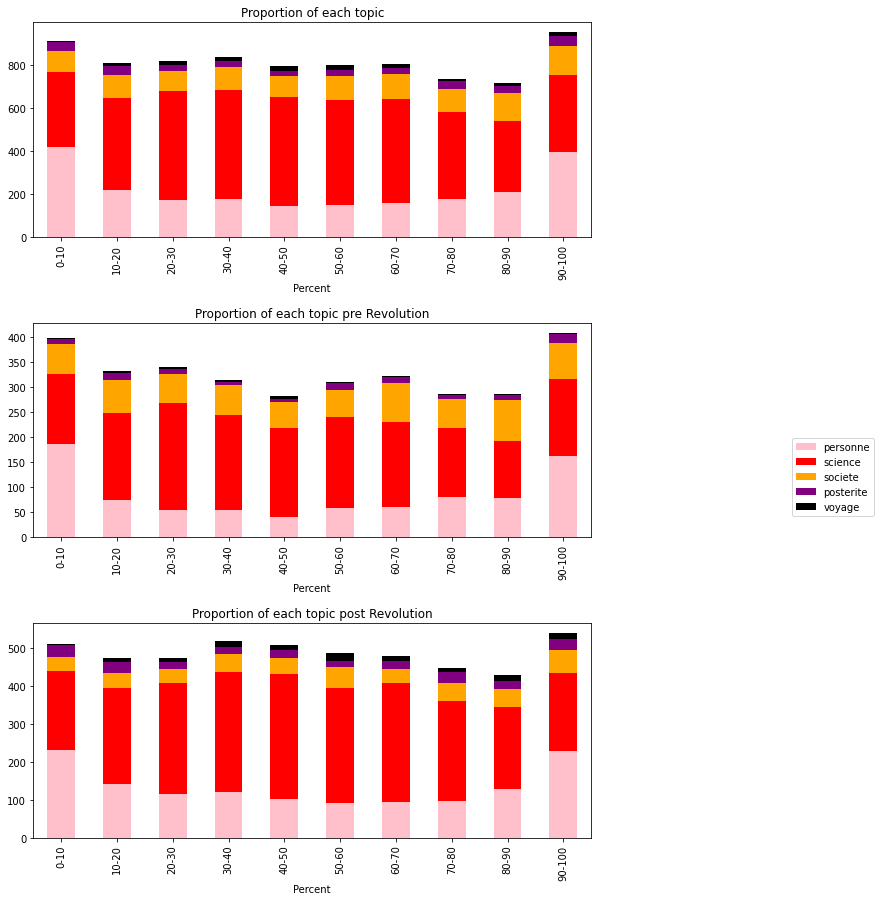

In [167]:
test,_,_ = plot_stack_bar(df_sent_hh)

144it [00:00, 6996.42it/s]
78it [00:00, 5492.51it/s]
66it [00:00, 1885.72it/s]


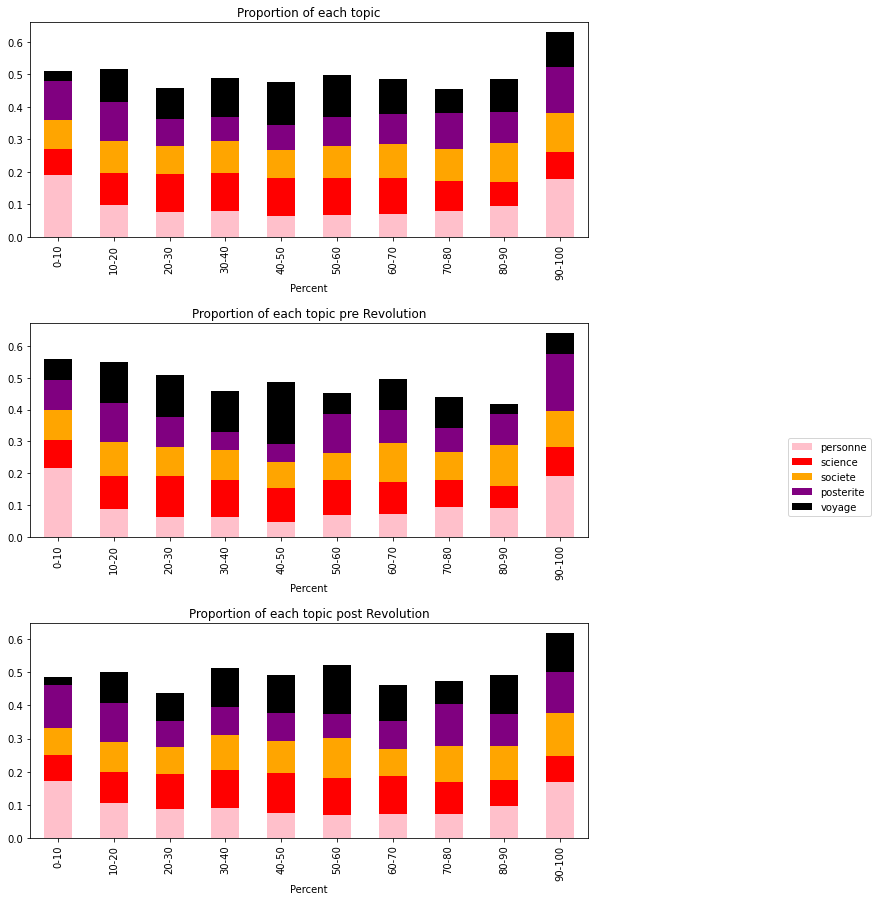

In [168]:
test,_,_ = plot_stack_bar(df_sent_hh, norm_by_tot=True)

No major differences

144it [00:00, 6948.13it/s]
78it [00:00, 4229.33it/s]
66it [00:00, 2786.49it/s]


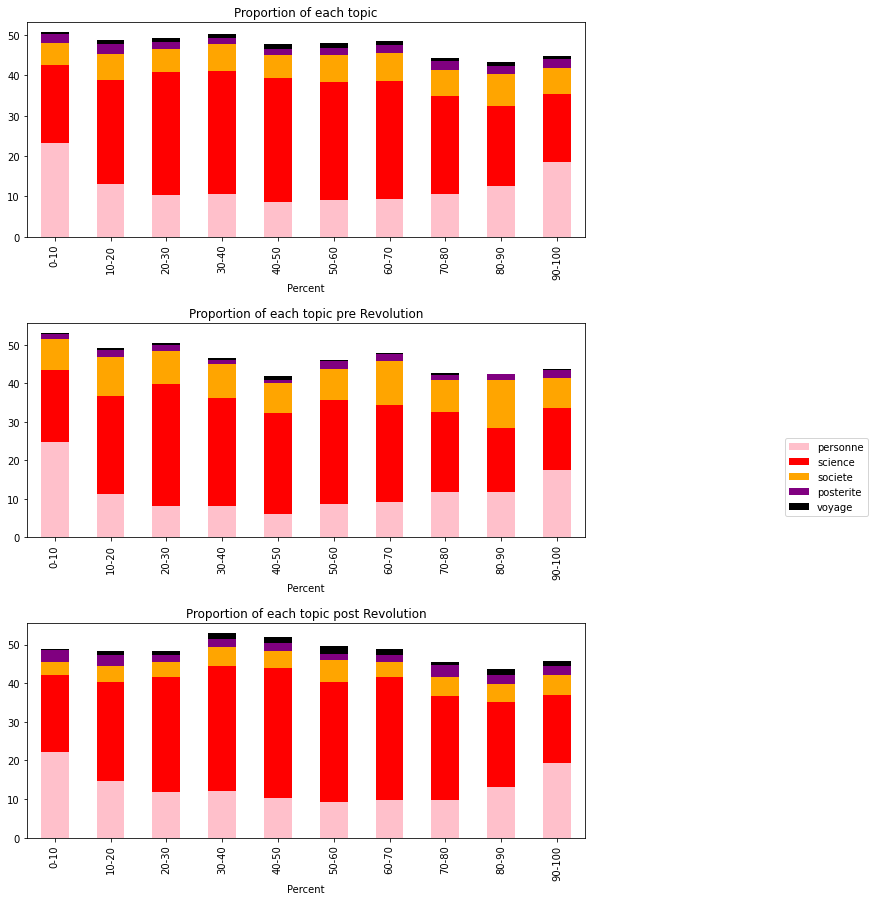

In [169]:
_,_,_ = plot_stack_bar(df_sent_hh, norm = True)

We speak more of politics before the Revolution, and more of travel after the Revolution

## By less higher topic

144it [00:00, 5311.30it/s]
78it [00:00, 2670.40it/s]
66it [00:00, 5651.20it/s]


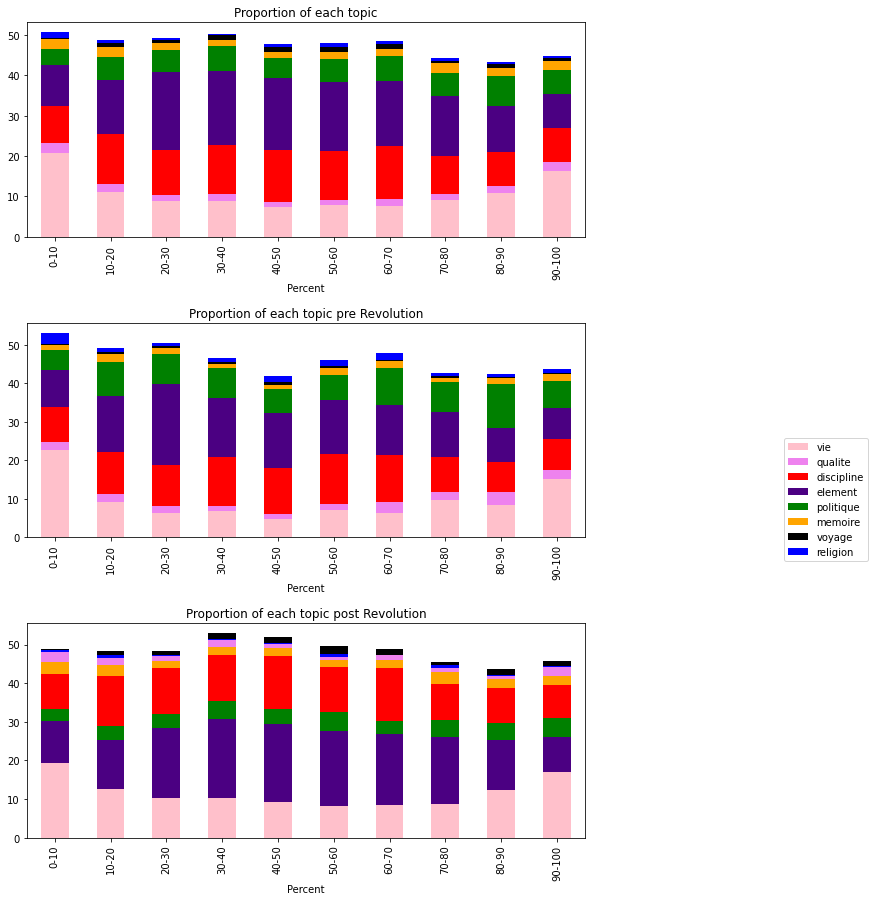

In [170]:
color_p = {'outlier' : 'grey', 'vie' : 'pink', 'qualite' : 'violet', 'discipline':
                                       'red', 'element' : 'indigo', 'memoire' : 'orange', 'politique' : 'green',
                                       'religion' : 'blue', 'voyage' : 'black'}
_,_,_=plot_stack_bar(df_sent_h, color_plot = color_p, norm = True, keep_outliers = False)

## Personne

In [254]:
df_vie = df_sent_t.copy()
df_vie['Topic_Ordered'] = df_vie['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_vie])

144it [00:00, 5346.61it/s]
78it [00:00, 4796.79it/s]
66it [00:00, 3380.31it/s]


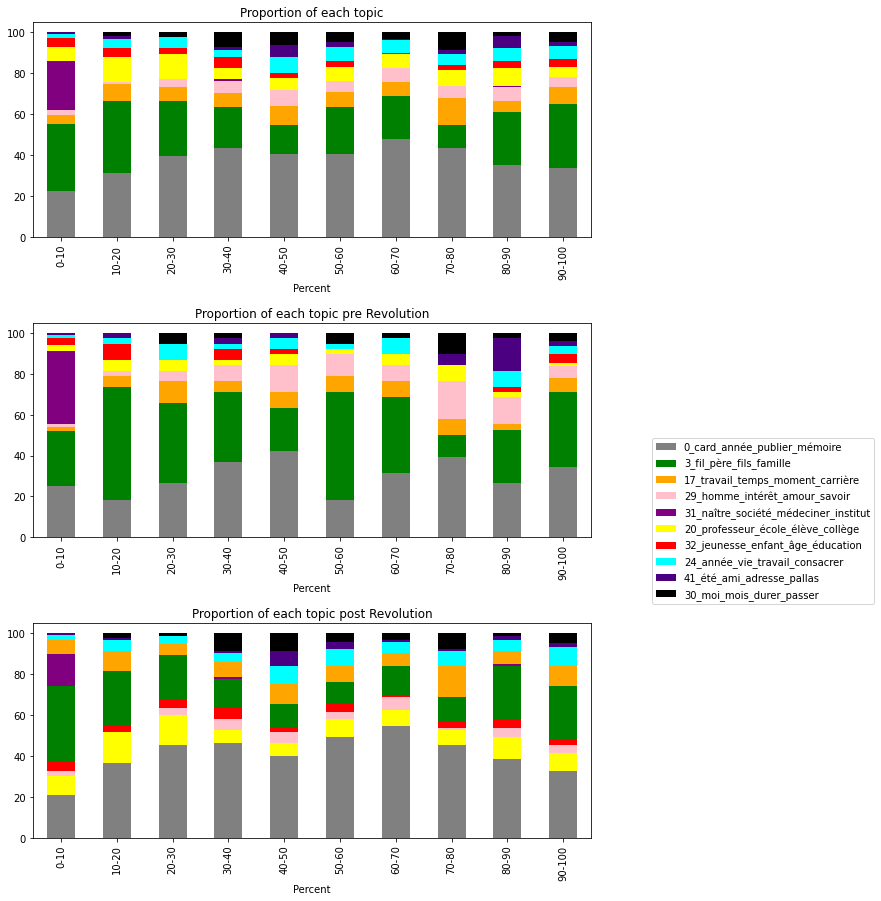

In [255]:
color_p = {'0_card_année_publier_mémoire' : 'grey', '3_fil_père_fils_famille' : 'green', '17_travail_temps_moment_carrière' :
          'orange', '29_homme_intérêt_amour_savoir' : 'pink', '31_naître_société_médeciner_institut' : 'purple',
          '20_professeur_école_élève_collège' : 'yellow', '32_jeunesse_enfant_âge_éducation' : 'red',
          '24_année_vie_travail_consacrer' : 'cyan', '41_été_ami_adresse_pallas' : 'indigo',
          '30_moi_mois_durer_passer' : 'black'}

_,_,_= plot_stack_bar(df_vie, keep_outliers = True, color_plot = color_p, norm = True)

On parle plus de la famille pre-revolution

## Jeunesse & mort

144it [00:00, 7275.20it/s]
78it [00:00, 3434.16it/s]
66it [00:00, 3780.92it/s]


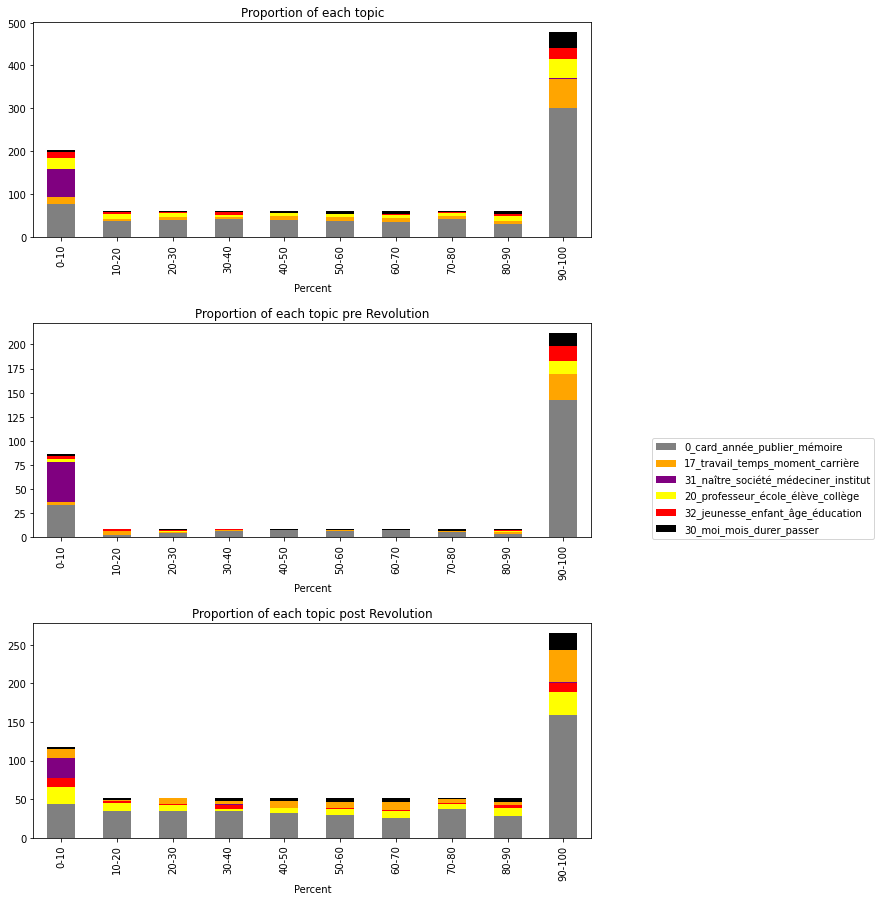

In [256]:
df_debut_fin = df_sent_t.copy()
df_debut_fin['Topic_Ordered'] = df_debut_fin['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in 
                                                                               [0, 17, 31, 20, 32, 30]])
_,_,_=plot_stack_bar(df_debut_fin, color_plot = color_p, keep_outliers=True, norm = False)

144it [00:00, 5224.20it/s]
78it [00:00, 2126.97it/s]
66it [00:00, 2543.82it/s]


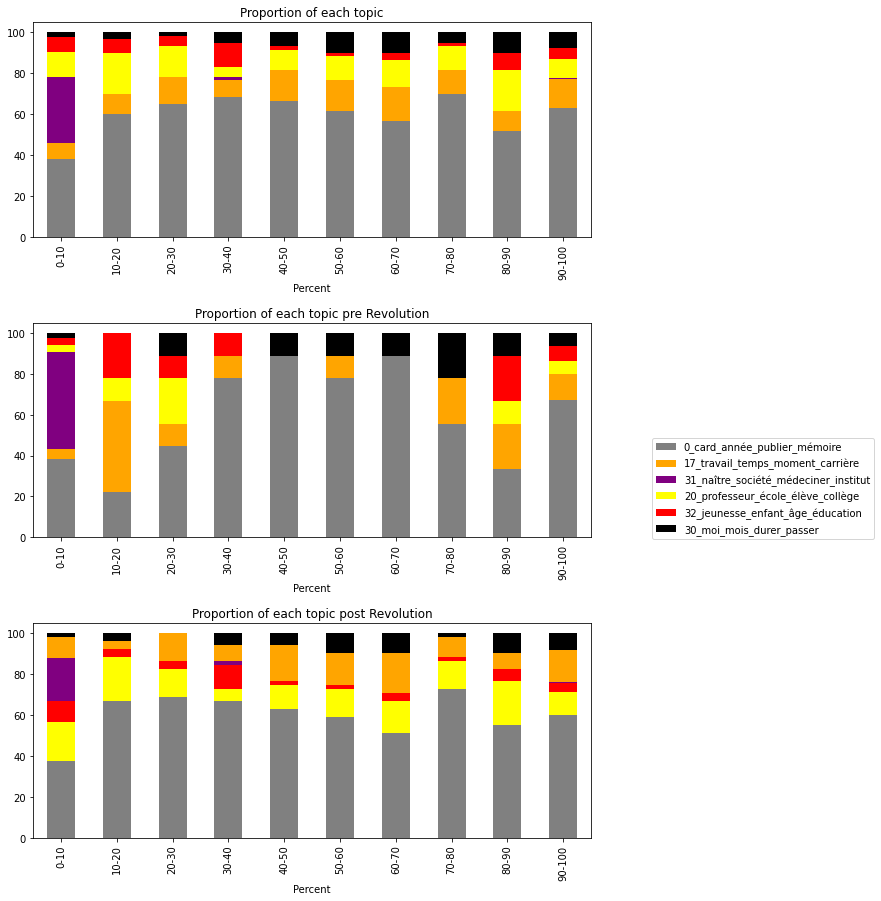

In [258]:
_,_,_=plot_stack_bar(df_debut_fin, color_plot = color_p, keep_outliers=True, norm = True)

Professeur plus évoqué tout le long de la vie après révolution et la jeunesse aussi

144it [00:00, 6033.40it/s]
78it [00:00, 5444.25it/s]
66it [00:00, 2460.02it/s]


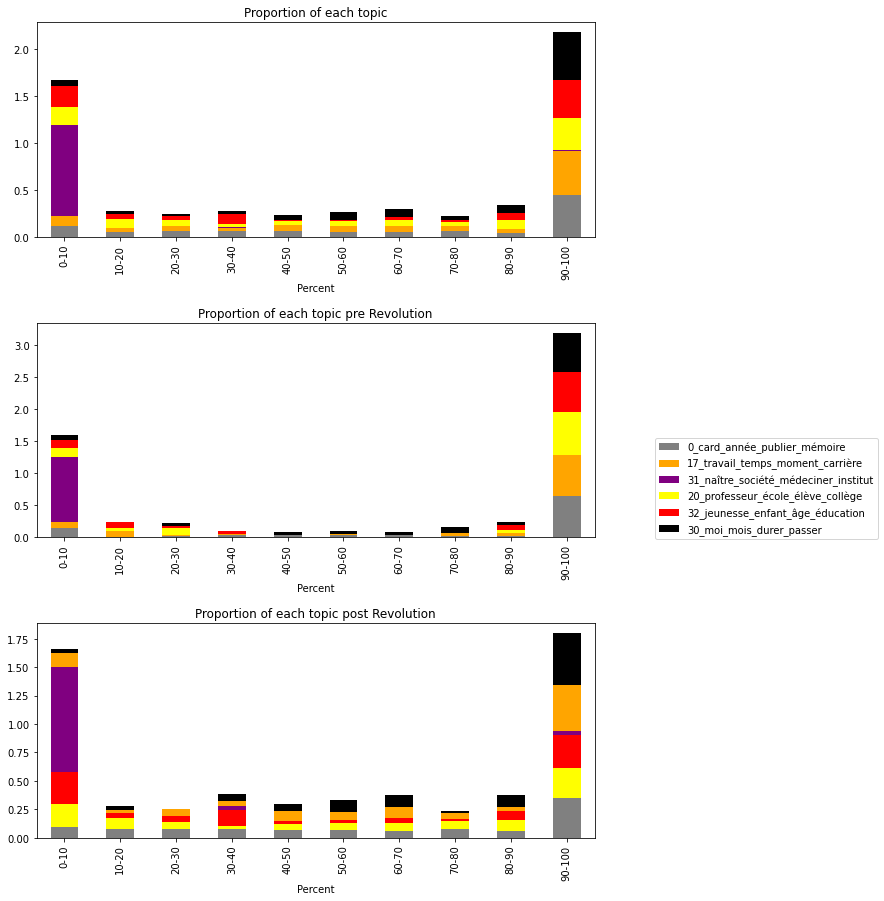

In [259]:
_,_,_=plot_stack_bar(df_debut_fin, color_plot = color_p, keep_outliers=True, norm_by_tot = True)

card, année publier mémoire évoqué tout le long de l'éloge après éa révolution tout comme progresseur et travail temps
Ce qui concerne la jeunesse semble plus réparti

## Relations

144it [00:00, 5140.12it/s]
78it [00:00, 4469.46it/s]
66it [00:00, 4848.65it/s]


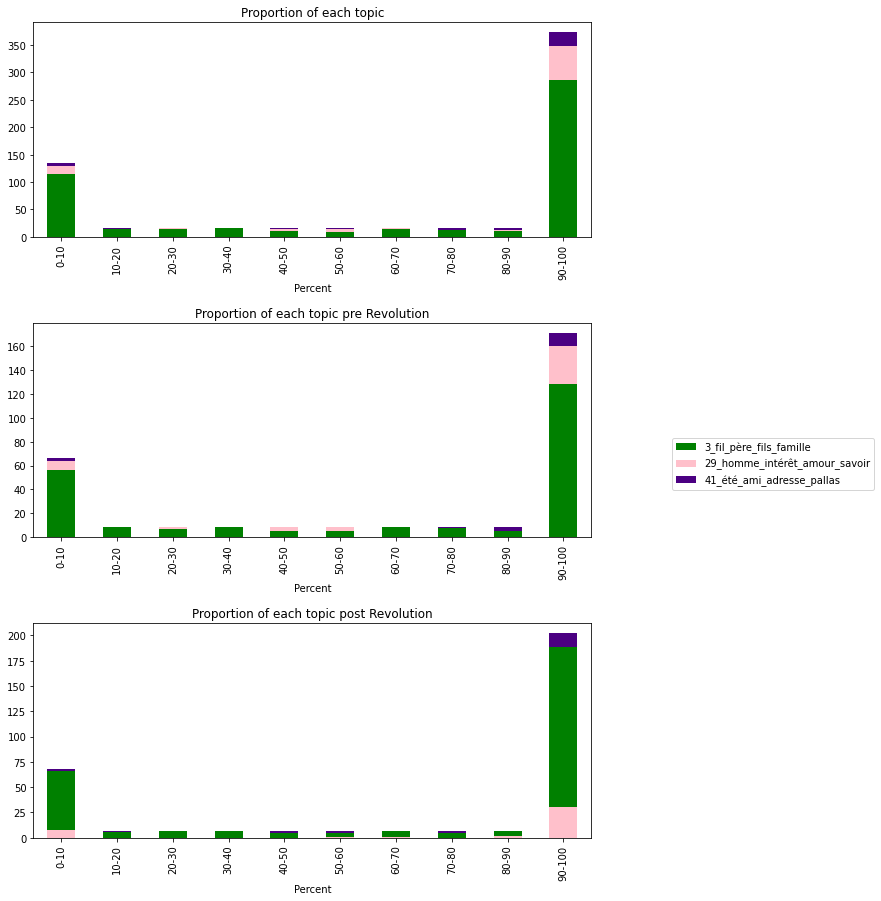

In [260]:
df_rel = df_sent_t.copy()
df_rel['Topic_Ordered'] = df_rel['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in [3,29,41]])

_,_,_=plot_stack_bar(df_rel, color_plot = color_p, keep_outliers=True, norm = False)

144it [00:00, 7598.47it/s]
78it [00:00, 5345.77it/s]
66it [00:00, 1711.30it/s]


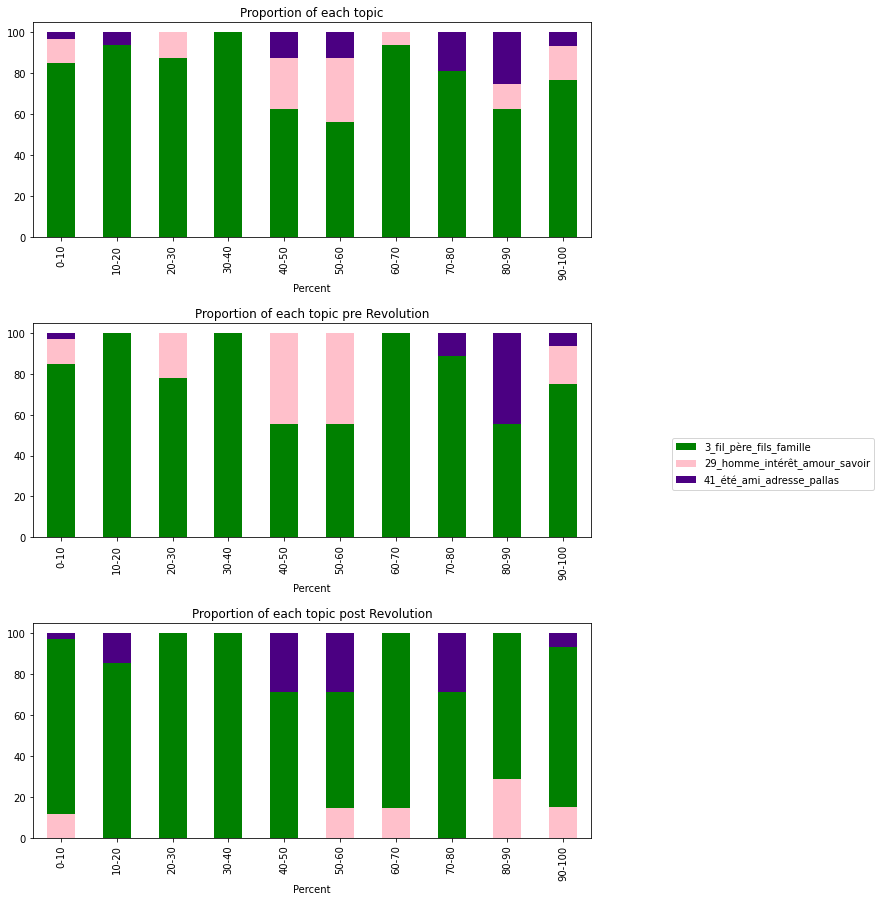

In [262]:

_,_,_=plot_stack_bar(df_rel, color_plot = color_p, keep_outliers=True, norm = True)

Amis plus évoqués après la révolution dans l'éloge

144it [00:00, 7553.90it/s]
78it [00:00, 5286.68it/s]
66it [00:00, 4019.05it/s]


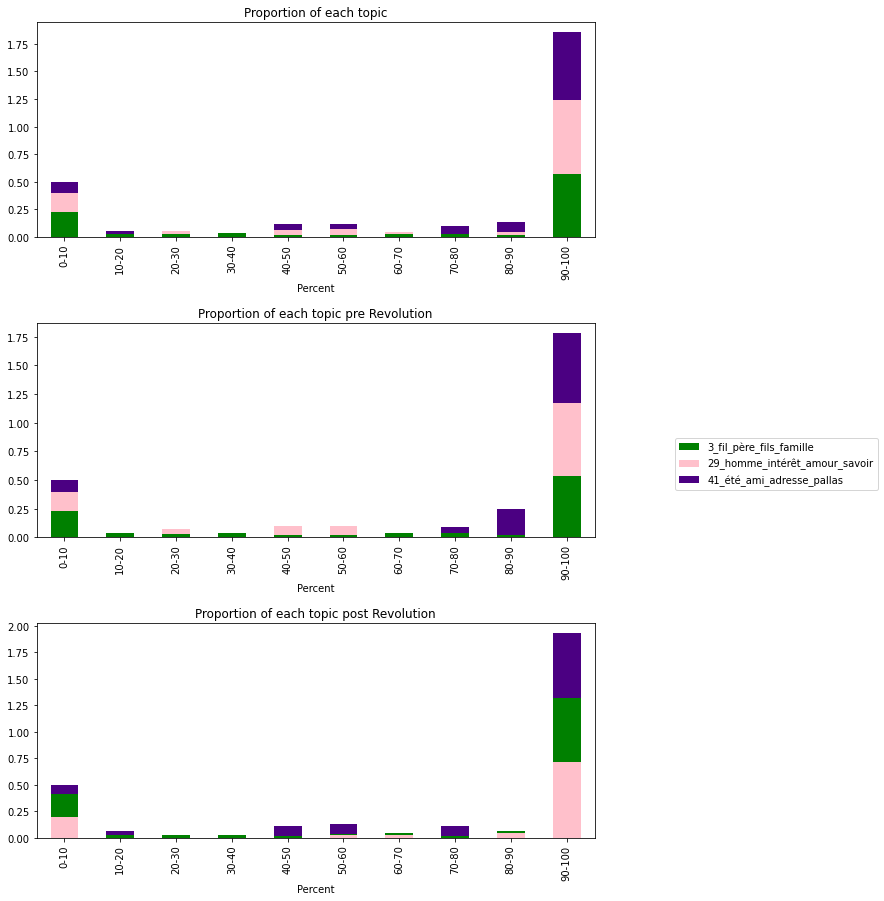

In [263]:
_,_,_=plot_stack_bar(df_rel, color_plot = color_p, keep_outliers=True, norm_by_tot = True)

Ami semble être à l'inverse de amour savoir

## Politique & Religion

In [264]:
df_pol = df_sent_t.copy()
df_pol['Topic_Ordered'] = df_pol['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_societe])

144it [00:00, 7534.96it/s]
78it [00:00, 4988.80it/s]
66it [00:00, 2742.92it/s]


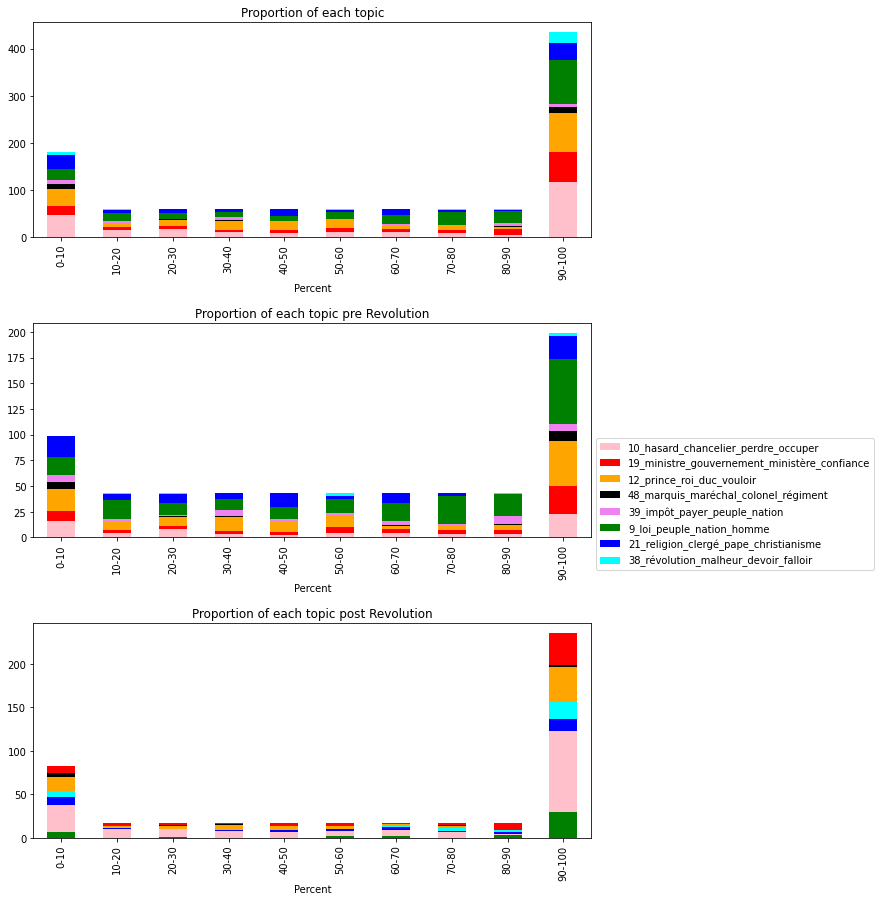

In [266]:
color_p = {'10_hasard_chancelier_perdre_occuper' : 'pink', '19_ministre_gouvernement_ministère_confiance' : 'red',
          '12_prince_roi_duc_vouloir' : 'orange', '48_marquis_maréchal_colonel_régiment' : 'black',
          '21_religion_clergé_pape_christianisme' : 'blue', '9_loi_peuple_nation_homme' : 'green',
          '39_impôt_payer_peuple_nation' : 'violet', '38_révolution_malheur_devoir_falloir' : 'cyan'}

_, _, _ = plot_stack_bar(df_pol, keep_outliers = True, color_plot = color_p, norm = False)

Politique plus évoquée tout le long de l'éloge avant la révolution, particulièrement loi peuple nation pas hasard chancelier occuper perdre

144it [00:00, 7252.22it/s]
78it [00:00, 4378.83it/s]
66it [00:00, 2486.63it/s]


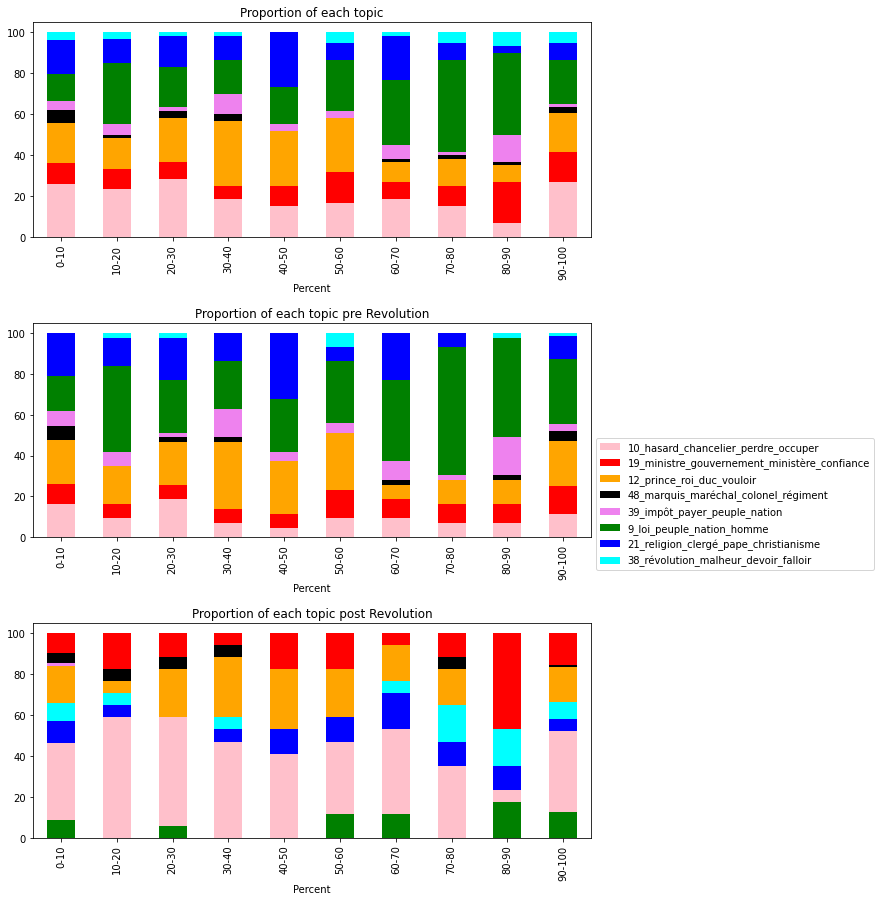

In [267]:
_, _, _ = plot_stack_bar(df_pol, keep_outliers = True, color_plot = color_p, norm = True)

Les deux sujets les plus importants post rev sont hasard chancelier perdre occuper et ministre ainsi que roi

Plus réparti avant la révolution

Religion a une part plus improtante avant la révolution

144it [00:00, 7595.41it/s]
78it [00:00, 3245.27it/s]
66it [00:00, 2772.62it/s]


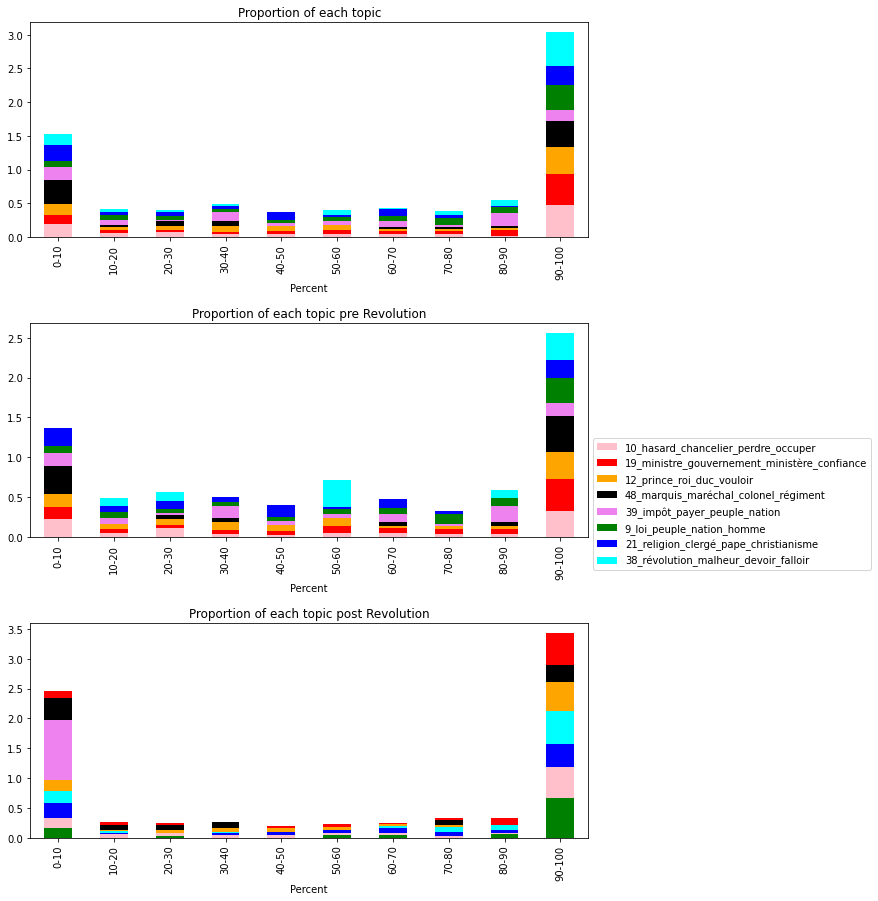

In [268]:
_, _, _ = plot_stack_bar(df_pol, keep_outliers = True, color_plot = color_p, norm_by_tot = True)

## Posterite

In [269]:
df_pos = df_sent_t.copy()
df_pos['Topic_Ordered'] = df_pos['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_posterite])

144it [00:00, 7784.15it/s]
78it [00:00, 3347.20it/s]
66it [00:00, 4115.24it/s]


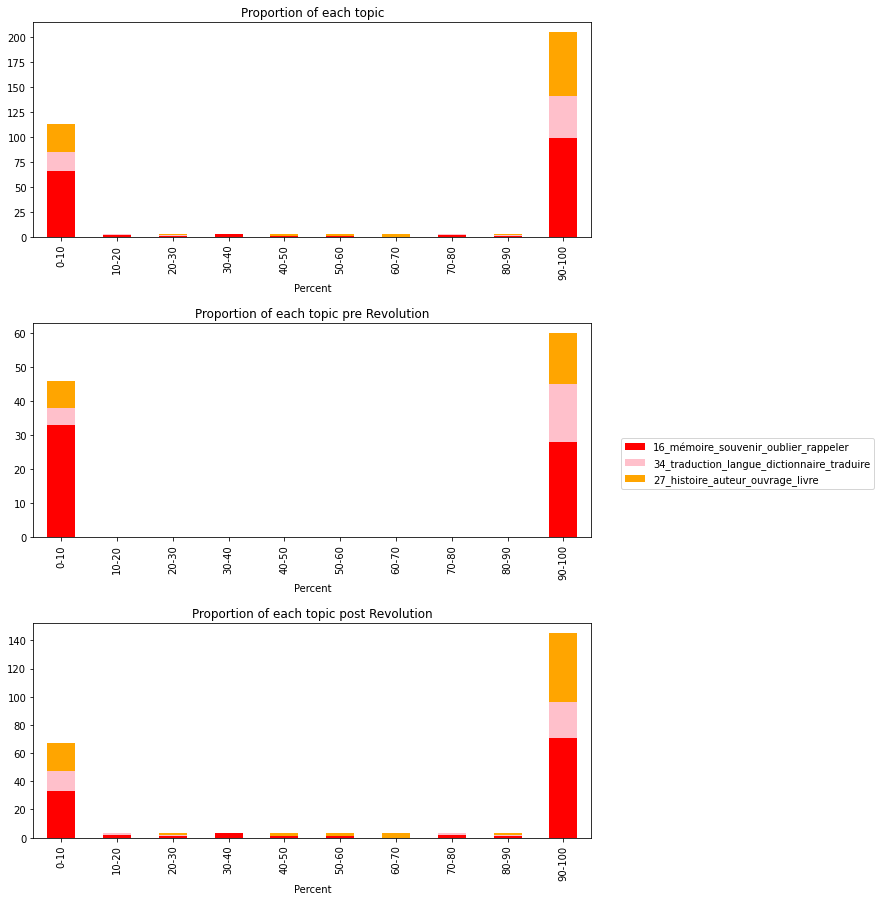

In [270]:
color_p = {'16_mémoire_souvenir_oublier_rappeler' : 'red', '34_traduction_langue_dictionnaire_traduire' : 'pink',
         '27_histoire_auteur_ouvrage_livre' : 'orange'}

_,_,_=plot_stack_bar(df_pos, keep_outliers = True, color_plot = color_p)

Postérité beaucoup plus présente dans l'éloge après la Révolution

144it [00:00, 5355.76it/s]
78it [00:00, 4468.67it/s]
66it [00:00, 5511.02it/s]


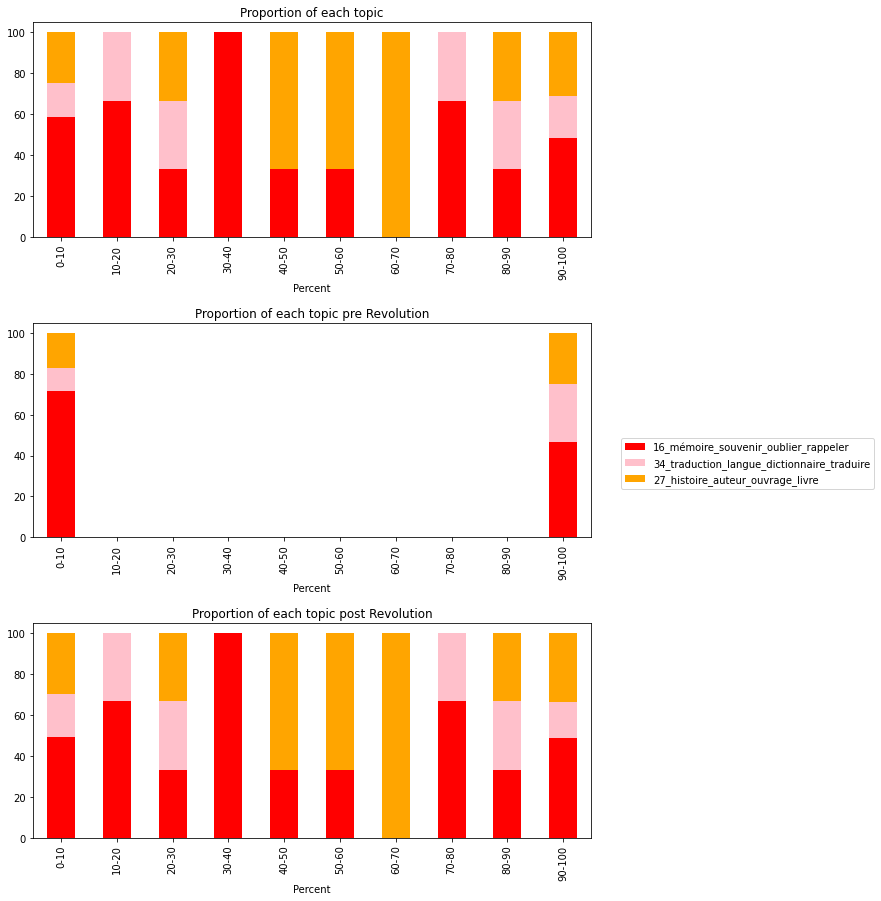

In [271]:
perc,_,_=plot_stack_bar(df_pos, keep_outliers = True, color_plot = color_p, norm = True)

Avant la révolution postérité discutée qu'au début et à la fin de l'éloge par rapport à après la Révolution

144it [00:00, 6878.73it/s]
78it [00:00, 5630.13it/s]
66it [00:00, 2385.35it/s]


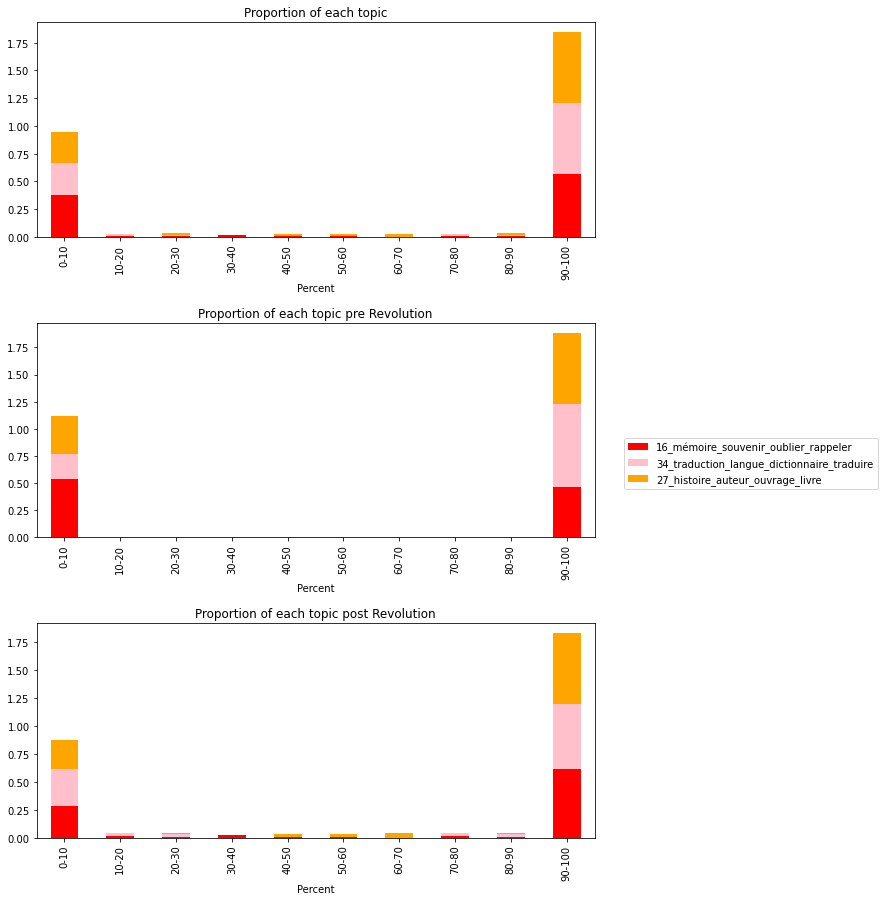

In [272]:
perc,_,_=plot_stack_bar(df_pos, keep_outliers = True, color_plot = color_p, norm_by_tot = True)

## Science

In [273]:
df_disc = df_sent_t.copy()
df_disc['Topic_Ordered'] = df_disc['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_discipline])

144it [00:00, 7375.59it/s]
78it [00:00, 4994.21it/s]
66it [00:00, 4246.55it/s]


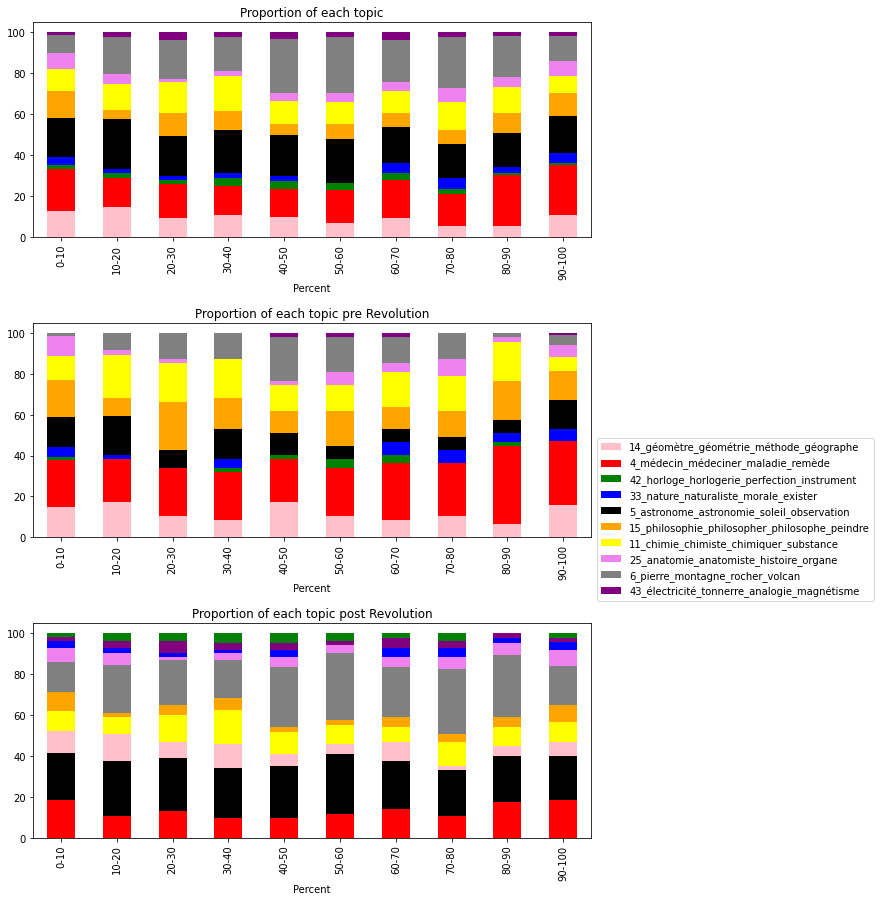

In [274]:
color_p = {'14_géomètre_géométrie_méthode_géographe'  : 'pink', '4_médecin_médeciner_maladie_remède' : 'red', 
          '42_horloge_horlogerie_perfection_instrument' : 'green', '33_nature_naturaliste_morale_exister' : 'blue',
          '5_astronome_astronomie_soleil_observation' : 'black', '15_philosophie_philosopher_philosophe_peindre' :
          'orange', '25_anatomie_anatomiste_histoire_organe' : 'violet', '6_pierre_montagne_rocher_volcan' :
          'grey', '11_chimie_chimiste_chimiquer_substance' : 'yellow', '43_électricité_tonnerre_analogie_magnétisme' :
          'purple'}

#, '26_anatomie_anatomiste_histoire_comparer' : 'cyan', '13_pierre_montagne_rocher_volcan' :
#          'magenta', '18_rayon_lumière_rayer_raire' : 'brown', '27_esprit_âme_penser_idée' : 'beige',
 #         '23_expérience_confirmer_répéter_tenter' : 'gold', '2_planter_plante_espèce_jardin' : 'silver'
perc,_,_ = plot_stack_bar(df_disc, keep_outliers = True, color_plot = color_p)

144it [00:00, 5034.09it/s]
78it [00:00, 5185.21it/s]
66it [00:00, 1967.62it/s]


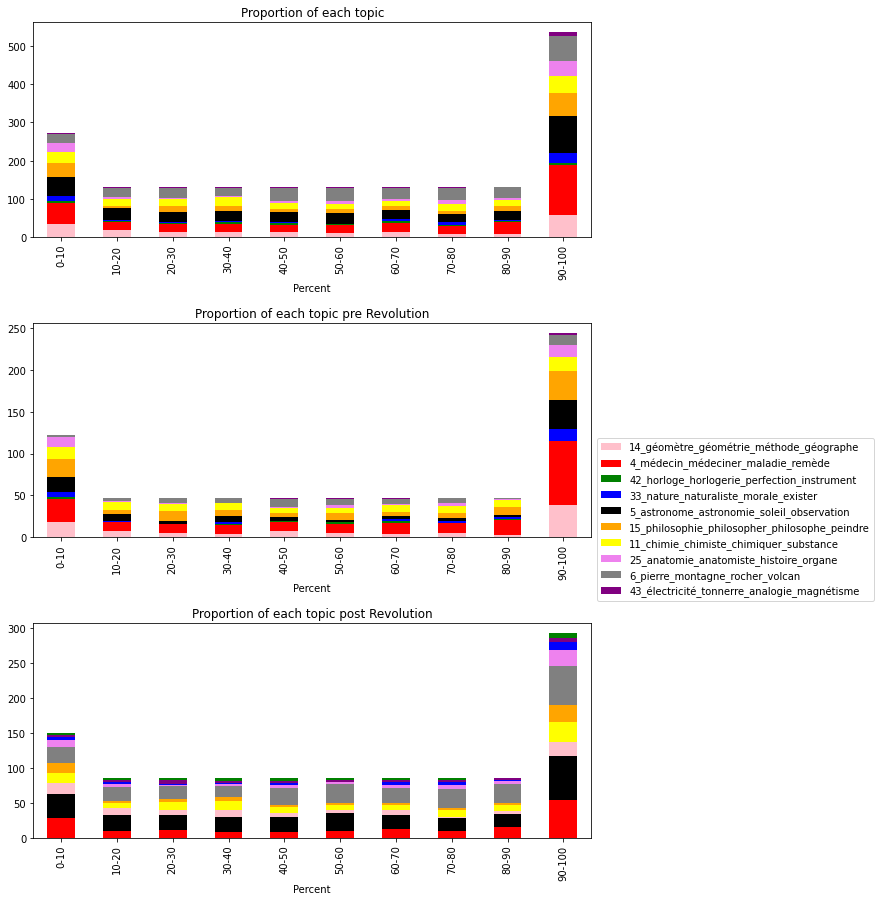

In [194]:
perc,_,_ = plot_stack_bar(df_disc, keep_outliers = True, color_plot = color_p)

On parle plus de science dans le milieu du texte

On parle plus de l'art du dessin et de la peinture et philo en proportion

## Element

In [195]:
df_elem = df_sent_t.copy()
df_elem['Topic_Ordered'] = df_elem['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_element])

144it [00:00, 7473.42it/s]
78it [00:00, 4532.56it/s]
66it [00:00, 3819.90it/s]


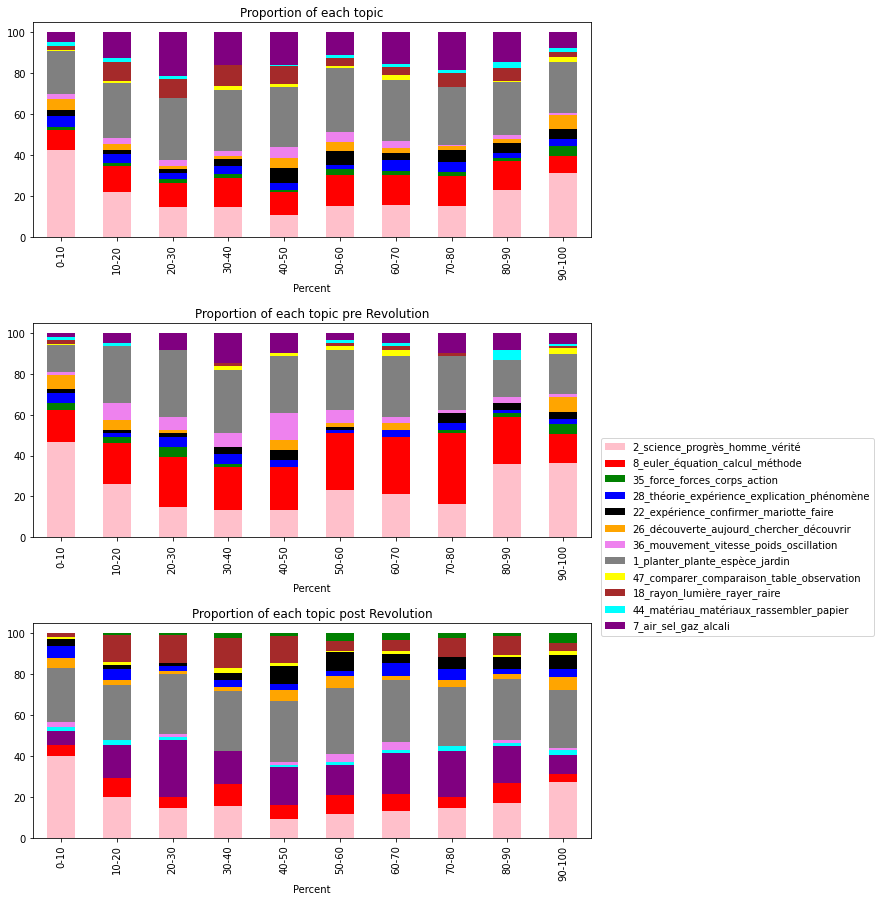

In [210]:
color_p = {'2_science_progrès_homme_vérité'  : 'pink', '8_euler_équation_calcul_méthode' : 'red', 
          '35_force_forces_corps_action' : 'green', '28_théorie_expérience_explication_phénomène' : 'blue',
          '22_expérience_confirmer_mariotte_faire' : 'black', '26_découverte_aujourd_chercher_découvrir' :
          'orange', '36_mouvement_vitesse_poids_oscillation' : 'violet', '1_planter_plante_espèce_jardin' :
          'grey', '47_comparer_comparaison_table_observation': 'yellow', '7_air_sel_gaz_alcali' :
          'purple', '44_matériau_matériaux_rassembler_papier' :
          'cyan', '18_rayon_lumière_rayer_raire' : 'brown'}#, '27_esprit_âme_penser_idée' : 'beige'}

perc,_,_ = plot_stack_bar(df_elem, keep_outliers = True, color_plot = color_p, norm = True)

144it [00:00, 4568.51it/s]
78it [00:00, 3779.26it/s]
66it [00:00, 4844.75it/s]


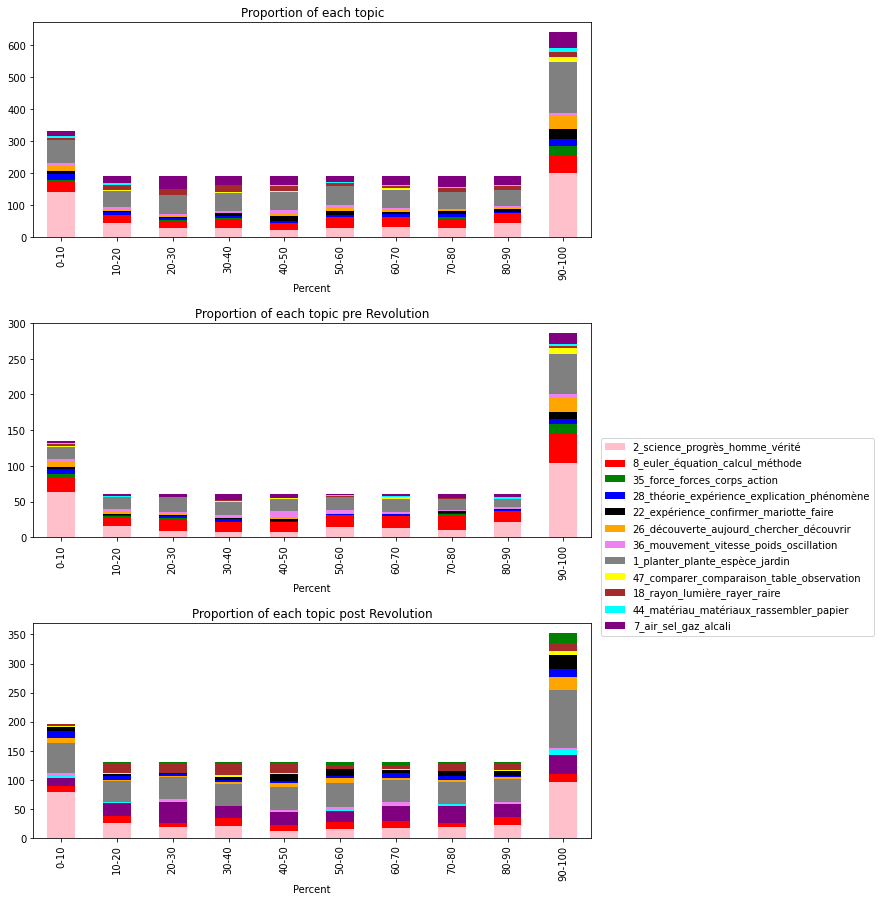

In [211]:
perc,_,_ = plot_stack_bar(df_elem, keep_outliers = True, color_plot = color_p)

## Voyage

144it [00:00, 7437.63it/s]
78it [00:00, 3662.16it/s]
66it [00:00, 3806.71it/s]


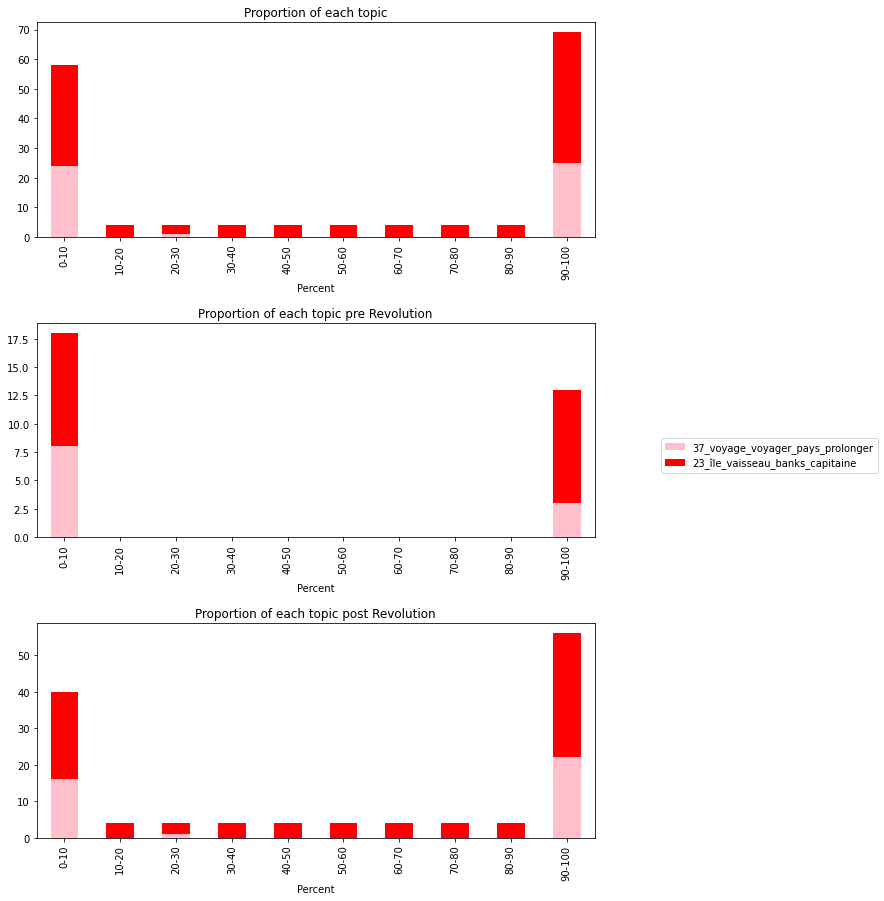

In [214]:
df_voy = df_sent_t.copy()
df_voy['Topic_Ordered'] = df_voy['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_voyage])

color_p = {'37_voyage_voyager_pays_prolonger'  : 'pink', '23_île_vaisseau_banks_capitaine' : 'red'}

perc,_,_ = plot_stack_bar(df_voy, keep_outliers = True, color_plot = color_p, norm = False)

# Assertivité

In [215]:
df_ass = pd.read_csv('./../../Data/Results/Adverbs.csv')


In [253]:
df_ass[df_ass['Assertivité']!='default value'][['Adverb', 'Assertivité']]

,Adverb,Assertivité
12,toujours,certain
16,jamais,certain
21,souvent,presque
23,peuttre,moitié
26,longtemps,jsp
29,surtout,jsp
40,quelquefois,peu
48,plutt,presque
49,partout,certain
55,entirement,jsp


In [252]:
df_ass['Assertivité'][18] = 'default value'

In [242]:
df_ass[df_ass['Temporalité']!='default value'][['Adverb', 'Temporalité']]

,Adverb,Temporalité
12,toujours,eternel
16,jamais,nul
21,souvent,presque
26,longtemps,presque
32,dj,tot
34,bientt,presque
40,quelquefois,peu
45,aujourdhui,tot
46,ensuite,suite
56,successivement,suite


In [241]:
df_ass['Temporalité'][68] = 'eternel'

In [232]:
df_ass[df_ass['Expérience']!='default value'][['Adverb', 'Expérience']]

,Adverb,Expérience
7,bien,plus
36,mieux,plus
51,fort,plus
54,heureusement,plus
74,mal,moins
83,malheureusement,moins
99,parfaitement,plus
220,convenablement,plus
223,gnreusement,plus
224,imprudemment,moins


In [223]:
df_ass['Expérience'][0]

nan

In [229]:
df_ass.fillna('default value', inplace = True)

In [294]:
df_other = pd.read_csv('./../../Data/Results/Adverbs.csv')

df_adv = pd.merge (df_other, df_ass, left_index = True, right_index=True)


In [296]:
df_adv.pop('Number_x')
df_adv.pop('Categorie_x')
df_adv.pop('Assertivité_x')
df_adv.pop('Temporalité_x')
df_adv.pop('Expérience_x')
df_adv.pop('Adverb_y')


,Adverb_x,Number_y,Categorie_y,Assertivité_y,Temporalité_y,Expérience_y
0,plus,5933,quantité,default value,default value,default value
1,ne,5339,négation,default value,default value,default value
2,pas,3139,négation,default value,default value,default value
3,n,2310,négation,default value,default value,default value
4,encore,1404,temps_quantité_logique,default value,default value,default value


In [298]:
df_adv.rename(columns = {'Number_y':'Number', 'Adverb_x':'Adverb', 'Categorie_y' : 'Catégorie',
                        'Temporalité_y' : 'Temporalité', 'Assertivité_y' : 'Assertivity'}, inplace=True)
df_adv.head()

,Adverb,Number,Catégorie,Assertivity,Temporalité,Expérience_y
0,plus,5933,quantité,default value,default value,default value
1,ne,5339,négation,default value,default value,default value
2,pas,3139,négation,default value,default value,default value
3,n,2310,négation,default value,default value,default value
4,encore,1404,temps_quantité_logique,default value,default value,default value


In [299]:
sent.head()

,Savant,Auteur,Annee,Eloge,no_sw,no_sw_no_punkt,tags,Eloge_lem,n_v
0,Fontaine,Condorcet,1771,Alexis Fontaine naquit à Claveison en Dauphiné...,"Alexis Fontaine naquit Claveison Dauphiné, l’a...",Alexis Fontaine naquit Claveison Dauphiné l a...,"[(Alexis, NAM, Alexis), (Fontaine, NAM, Fontai...",Alexis Fontaine naître Claveison Dauphiné l an...,naître année card
1,Fontaine,Condorcet,1771,Il avait environ vingt ans lorsque son père m...,ans père mourut,ans père mourut,"[(ans, NOM, an), (père, NOM, père), (mourut, V...",an père mourir,père mourir
2,Fontaine,Condorcet,1771,Ses parents auraient voulu qu’il suivit les é...,"Ses parents voulu qu’il suivit études droit, n...",Ses parents voulu qu il suivit études droit n...,"[(Ses, DET:POS, son), (parents, NOM, parents),...",son parents vouloir qu il suivre étude droit n...,vouloir étude exercer charge styler commentate...
3,Fontaine,Condorcet,1771,Né avec cette rigueur d’esprit que les démons...,"rigueur d’esprit démonstrations satisfaire, do...",rigueur d esprit démonstrations satisfaire do...,"[(rigueur, NOM, rigueur), (d, VER:futu, d), (e...",rigueur d esprit démonstration satisfaire donn...,rigueur esprit démonstration satisfaire donner...
4,Fontaine,Condorcet,1771,Tourmenté par les sollicitations de ses paren...,"Tourmenté sollicitations parents, l’activité g...",Tourmenté sollicitations parents l activité g...,"[(Tourmenté, VER:pper, tourmenter), (sollicita...",tourmenter sollicitation parent l activité gén...,tourmenter sollicitation activité génie provin...


In [290]:
adv = keep_adv(sent, 'Eloge_lem')

100%|████████████████████████████████████| 17177/17177 [00:34<00:00, 500.30it/s]


In [302]:
ls_ass = df_adv[df_adv['Assertivity']!='default value']['Adverb'].tolist()
ls_temp = df_adv[df_adv['Temporalité']!='default value']['Adverb'].tolist()
ls_exp = df_adv[df_adv['Expérience_y']!='default value']['Adverb'].tolist()

In [303]:
adv.head()

,Savant,Auteur,Annee,Eloge,no_sw,no_sw_no_punkt,tags,Eloge_lem,n_v,adverbs
0,Fontaine,Condorcet,1771,Alexis Fontaine naquit à Claveison en Dauphiné...,"Alexis Fontaine naquit Claveison Dauphiné, l’a...",Alexis Fontaine naquit Claveison Dauphiné l a...,"[(Alexis, NAM, Alexis), (Fontaine, NAM, Fontai...",Alexis Fontaine naître Claveison Dauphiné l an...,naître année card,[]
1,Fontaine,Condorcet,1771,Il avait environ vingt ans lorsque son père m...,ans père mourut,ans père mourut,"[(ans, NOM, an), (père, NOM, père), (mourut, V...",an père mourir,père mourir,[]
2,Fontaine,Condorcet,1771,Ses parents auraient voulu qu’il suivit les é...,"Ses parents voulu qu’il suivit études droit, n...",Ses parents voulu qu il suivit études droit n...,"[(Ses, DET:POS, son), (parents, NOM, parents),...",son parents vouloir qu il suivre étude droit n...,vouloir étude exercer charge styler commentate...,[]
3,Fontaine,Condorcet,1771,Né avec cette rigueur d’esprit que les démons...,"rigueur d’esprit démonstrations satisfaire, do...",rigueur d esprit démonstrations satisfaire do...,"[(rigueur, NOM, rigueur), (d, VER:futu, d), (e...",rigueur d esprit démonstration satisfaire donn...,rigueur esprit démonstration satisfaire donner...,"[ailleurs, guère, bien, souvent]"
4,Fontaine,Condorcet,1771,Tourmenté par les sollicitations de ses paren...,"Tourmenté sollicitations parents, l’activité g...",Tourmenté sollicitations parents l activité g...,"[(Tourmenté, VER:pper, tourmenter), (sollicita...",tourmenter sollicitation parent l activité gén...,tourmenter sollicitation activité génie provin...,[]


In [307]:
adv['Assertivité'] = adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_ass]))
adv['Temporalité'] = adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_temp]))
adv['Expérience'] = adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_exp]))

In [318]:
ass = adv.groupby(['Annee']).agg({'Assertivité'  : 'sum', 'Eloge' : 'count'})
temp = adv.groupby(['Annee']).agg({'Temporalité'  : 'sum', 'Eloge' : 'count'})
exp = adv.groupby(['Annee']).agg({'Expérience'  : 'sum', 'Eloge' : 'count'})

In [319]:
ass['Assertivité'] = ass.apply(lambda row : row['Assertivité']/row['Eloge'], axis = 1)
temp['Temporalité'] = temp.apply(lambda row : row['Temporalité']/row['Eloge'], axis = 1)
exp['Expérience'] = exp.apply(lambda row : row['Expérience']/row['Eloge'], axis = 1)

<AxesSubplot:xlabel='Annee'>

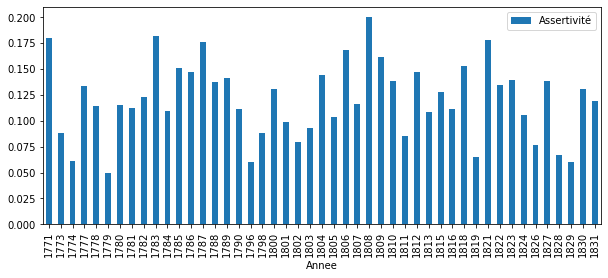

In [321]:
ass.plot.bar( y= 'Assertivité',figsize = (10,4))

<AxesSubplot:xlabel='Annee'>

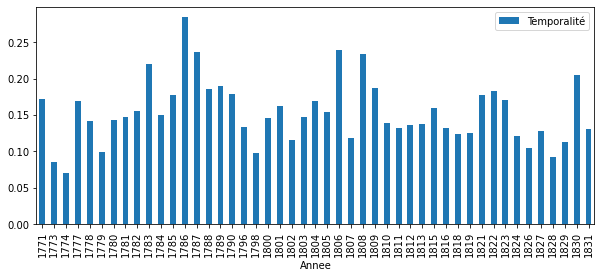

In [322]:
temp.plot.bar(y = 'Temporalité', figsize = (10,4))

<AxesSubplot:xlabel='Annee'>

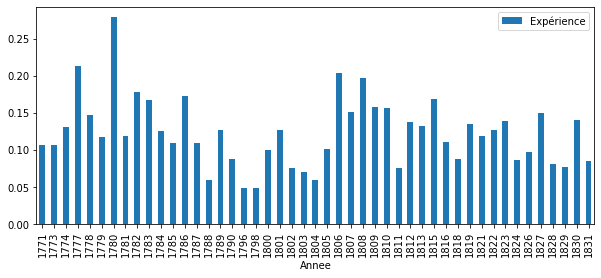

In [323]:
exp.plot.bar(y = 'Expérience', figsize = (10,4))